# Applied Statistics 2021 problem set
## Solution by Robert Larsen



## Section 1: Imports and definitions

In [1]:
#Importing standard packages:
import numpy as np                                     
import matplotlib.pyplot as plt                        
import seaborn as sns                                  
from iminuit import Minuit                             
import sys 
from scipy import stats
import scipy as sci
from sympy import *
from IPython.core.display import Latex

sys.path.append('../External_Functions')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [2]:
#Defining some usefull functions for later:

def lprint(*args,**kwargs):
    """Pretty print arguments as LaTeX using IPython display system 
    
    Parameters
    ----------
    args : tuple 
        What to print (in LaTeX math mode)
    kwargs : dict 
        optional keywords to pass to `display` 
    """
    display(Latex('$$'+' '.join(args)+'$$'),**kwargs)

def AnalyticalErrorProp(f,Args=None,verbose=False):
#f is Expression we want to propagate on
#Args is list of arguments to pass to f
    
    if Args is None:
        Args = list(f.free_symbols)
    
    V=MatrixSymbol("V",len(Args),len(Args)) #Covariance matrix
    
    DV=[] #derivative vector
    
    for arg in Args:
        DV.append(f.diff(arg)) #append all the derivaives
            
    DV=Matrix(DV) #make into vector
       
    df2=DV.T*V*DV #simply do matrix multiplication to get df2
    df=sqrt(df2) #take sqrt

    if verbose:
        lprint(latex(df))
    
    return df,V

def plot2Dhist(x,y,bins=[100, 100],RangeStd=1):
    #simply plots a 2D histogram
    #RagneStd is how many standard deviations away from mean we want to plot.
    
    Range=[[np.mean(x)-RangeStd*np.std(x), np.mean(x)+RangeStd*np.std(x)], [np.mean(y)-RangeStd*np.std(y), np.mean(y)+RangeStd*np.std(y)]]
    
    fig, ax = plt.subplots(figsize=(14, 8))
    counts, xedges, yedges, im = ax.hist2d(x, y, bins=bins, range= Range, cmin=1)
    fig.colorbar(im) # ticks=[-1, 0, 1]

    ax.set(title='Histogram of x and y',
           xlabel='x', 
           ylabel='y',
           aspect='equal', # NOTE: This forces the x- and y-axis to have the SAME scale!!!
          )

    d = {'Entries': 2,
         'Mean x': x.mean(),
         'Mean y': y.mean(),
         'Std x': x.std(ddof=1),
         'Std y': y.std(ddof=1),
         'correlation' : np.cov(x,y)[0,1]/(x.std(ddof=1)*y.std(ddof=1)),
        }

    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.02, 0.97, text, ax, fontsize=15);

    fig.tight_layout()

def plot1Dhist(x,RangeStd=1,PlotGaussian=True,Title="Title",xlabel="Label",plotRange=None):
    #1D version of above
    #Will also put a gaussian with the calculated mean and std on top
    
    nbins = int(np.sqrt(len(x)))
    
    if plotRange is not None:
        xmin, xmax = plotRange[0],plotRange[1]
    else:
        xmin, xmax = np.mean(x)-RangeStd*np.std(x), np.mean(x)+RangeStd*np.std(x)
    binwidth = (xmax-xmin)/nbins
    
    fig2, ax2 = plt.subplots(figsize=(16, 6));
    counts, bin_edges, _ = ax2.hist(x, nbins, range=(xmin, xmax), histtype='step', linewidth=2)
    
    mean = x.mean()
    std = x.std(ddof=1)
    
    plt.ylabel("Frequency")
    plt.xlabel(xlabel)
    plt.title(Title)
    
    def gaussian(x, N, mu, sigma):
        return N * binwidth / (sigma*np.sqrt(2*np.pi)) * np.exp(-0.5* (x-mu)**2/sigma**2)
    if PlotGaussian:
        xaxis = np.linspace(xmin, xmax, 1000)
        yaxis = gaussian(xaxis, len(x), mean, std)
        ax2.plot(xaxis, yaxis, linewidth=2)
        fig2.tight_layout()
        fig2
    
def NumericalErrorPropagation(f,V,mu,N=1000,plotting=False,verbose=False,seed=42,dir1=0,dir2=1,plotRange=None,filename=""):
    #f is function (Has to take arguments as a list!)
    #V is covriance matrix
    #mu is vector of means
    #Function then simply does a numerical error propagation via monte-carlo simulation.
    
    #Setup RNG
    r=np.random
    r.seed(seed)
    
    Samples=r.multivariate_normal(mu,V,size=N)
        
    
    if plotting: #Will plot sample-distribution in chosen directions
        if len(mu)>1:
            plot2Dhist(Samples[:,dir1],Samples[:,dir2],bins=[np.sqrt(N),np.sqrt(N)],RangeStd=4)
        else: #only 1D sample    
            plot1Dhist(Samples,RangeStd=4,PlotGaussian=False,Title="Samples",xlabel="Sample value")
            
    Results=f(Samples.T)

    if plotting:
        if plotRange is not None:
             plot1Dhist(Results,RangeStd=3,Title="Results",xlabel="Result value",plotRange=plotRange)
        else:
            plot1Dhist(Results,RangeStd=3,Title="Results",xlabel="Result value")
    
    if verbose:
        print(f"Mean is {np.mean(Results):.3f}")
        print(f"Std is {np.std(Results):.3f}")
    plt.savefig(filename,dpi=600)
    return Results.std(ddof=1), Results, Samples


## Section 2: Solutions

### Problem 1
#### 1.1
##### a)

We are asked what distrubution our results will follow if we roll 20 D6 and count how many times we get a specific result. This must be a binomial distrubution, as we have a definite p_sucess (1/6) and a definite number of trials (20) (barlow p. 24-27). 

##### b)

If we want the probability of getting z sucesses or more, we simply have to compute one minus the cdf of the binomial distribution at z, as the cdf at z it the probability of obtaining fewer than z sucesses. 

We compute:


In [3]:
p=1/6
k=7
n=20

prob=stats.binom.sf(k-1,n,p) #-1 since we are including k
print(f"The probability of getting {k} or more threes is: {prob:.4f}")

The probability of getting 7 or more threes is: 0.0371


This was a super boring math-way of solving the exercise. Lets instead see if we get the same if we simulate our way out of the problem:


The probability of getting 7 or more threes is: 0.0370 (from simulation)


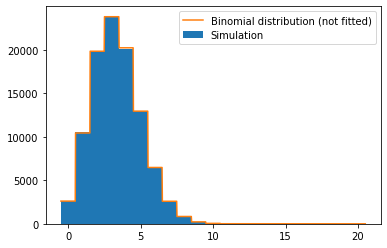

In [4]:
N=100000 #Number of times we roll 20 dice

r=np.random
r.seed(42)
    
R=r.random((N,n)) #Roll the dice
Result=np.where(R<p,1,0)
Result=np.sum(Result,axis=1)

Nbins=n+1
counts,bin_edges,_=plt.hist(Result,bins=Nbins,range=(0-0.5,n+0.5),label="Simulation") #PLot
x=np.linspace(-0.5,n+0.5,1000)
x_compute=np.round(x)
binwidth=(n+1)/Nbins
plt.plot(x,binwidth*N*stats.binom.pmf(x_compute,n,p),label="Binomial distribution (not fitted)")

plt.legend()
plt.savefig("1_1_b.png")
prob_sim=np.sum(counts[k::])/N #compute fraction with 7 or above

print(f"The probability of getting {k} or more threes is: {prob_sim:.4f} (from simulation)")


We see that both methods indeed agree that the probability is 3.7%, and the plot also shows excellent agreement, confirming my conclusion that it should be binonmally distributed. 

#### 1.2
##### a)
In this problem we consider tests of a disease. Given that the teset have no errors, the fraction of positives is simply given by the positives over the total nuber of tests:


In [5]:
N_AntiGen=26162
pos_AntiGen=491
N_PCR=103261
pos_PCR=2464


q_pos_AntiGen=pos_AntiGen/N_AntiGen
q_pos_PCR=pos_PCR/N_PCR

print(f"fraction of postives for Antigen is {q_pos_AntiGen:.5f}")
print(f"fraction of postives for PCR is {q_pos_PCR:.5f}")


fraction of postives for Antigen is 0.01877
fraction of postives for PCR is 0.02386


Since we have a case of small probability of being infected, and a large number of people being tested, we should expect poissonian statistics. Then the uncertainty on the number of positives is simply the square root of the number of positives. 

In [6]:
eq_pos_AntiGen=np.sqrt(pos_AntiGen)/N_AntiGen
eq_pos_PCR=np.sqrt(pos_PCR)/N_PCR

print(f"fraction of postives for Antigen is {q_pos_AntiGen:.4f} +- {eq_pos_AntiGen:.4f}")
print(f"fraction of postives for PCR is {q_pos_PCR:.4f} +- {eq_pos_PCR:.4f}")

fraction of postives for Antigen is 0.0188 +- 0.0008
fraction of postives for PCR is 0.0239 +- 0.0005


We do a chisquaretest to check the probability that these two numbers are sampling the same distribution:


In [7]:
q=np.array([q_pos_AntiGen,q_pos_PCR])
eq=np.array([eq_pos_AntiGen,eq_pos_PCR])

weights=(1/eq**2)/np.sum(1/eq**2)
q_average=np.average(q,weights=weights)

chi2=np.sum((q-q_average)**2/eq**2)
chi2_prob = stats.chi2.sf(chi2,len(q)-1) #used one degree of freedom in 'fit'

print(f"p-value is: {chi2_prob:}")

p-value is: 1.6877632601383728e-07


It is very unlikely that the tests are sampling the same distribution. Probably both tests have errors that are different. 

##### b)
We now assume the test are sampling the same population, so they both try to measure the underlying true positive-rate. We assume the only error present is a chance for the AntiGen test to give a false negative. We want to determine the rate of false negatives. 

If this is the only error, the fraction of positives measured by the PCR test must be accurate. The difference in the fractions must then give the fraction of false negatives of the AntiGen test. This we then divide by the fraction of true positives (from the assumed faultless PCR) to obtain the rate.


In [8]:
q_false=q_pos_PCR-q_pos_AntiGen
eq_false=np.sqrt(eq_pos_PCR**2+eq_pos_AntiGen**2) #From error-propagation
print(f"false negative fraction is: {q_false:.5f} +- {eq_false:.5f}")

r_false=q_false/q_pos_PCR
er_false=np.sqrt((eq_pos_PCR*q_pos_AntiGen/(q_pos_PCR**2))**2+(eq_pos_AntiGen/q_pos_PCR)**2)#more error-propagation
print(f"false negative rate is: {r_false:.5f} +- {er_false:.5f}")

false negative fraction is: 0.00509 +- 0.00097
false negative rate is: 0.21349 +- 0.03887


This is a pretty high rate of false negatives, one in 5 true positives will be missed. 

##### c)
We now consider a test with 0.02% false positive rate (denote this x) and 20% false negative rate (denote this y). We test 50000 people (denote this number N) and find 47 positive results. We are then asked to estimate the number of infected in the population. 

Let us assume that the tested people are a representative sample of the population. Then if a fraction p of the total populaiton is infected, we should expect $p \cdot N$ of the sample to be infected and $(1-p) \cdot N$ to be not infected. Then when testing we should get $(1-p) \cdot N \cdot x$ false positives, $p \cdot N \cdot y$ false negatives and $p \cdot N \cdot (1-y)$ true positives. Summing to $M=p \cdot N \cdot (1-y) + (1-p) \cdot N \cdot x$ positive test results. Solving for p yields: $p=(\frac{M}{N}-x) \cdot (1-x-y)^{-1}$

So our first estimate should simply be plugging the numbers into this equation:


In [9]:
M=47
N=50000
x=0.0002
y=0.2

p=(M/N-x)/(1-x-y)

ep = np.sqrt(M)*(1/N)/(1-x-y) #Assume poisson stats for M and use error-propagation

print(f"Estimated fraction of population infected: {p:.5f} +- {ep:.5f}")
print(f"Estimated number of people in sample infected: {p*N:.2f}")
print(f"Estimated false positives in sample: {(1-p)*N*x:.2f}")
print(f"Estimated false negatives in sample: {p*N*y:.2f}")
print(f"M/N: {M/N:.5f}")

Estimated fraction of population infected: 0.00093 +- 0.00017
Estimated number of people in sample infected: 46.26
Estimated false positives in sample: 9.99
Estimated false negatives in sample: 9.25
M/N: 0.00094


Remarkably the false negatives almost perfectly cancel the false positives, and M/N is actually a pretty good estimate of the true rate. 

#### 1.3

##### a) + b)
We are given a data-set, and are asked to plot it nicely.
We then want to fit the peaks we can find in the spectrum.

NOTE: I was a bit cunfused by the wording of the problem, so I have essentially solved two problems in parallel, since I was not certain if I was asked to find peaks in the raw data, as there looks to be consistent measurements of high voltages, or peaks in the histogram of the data, corresponding to measuring the same voltage many times. I think the problem asks for the latter, but just to be sure (and since I put a lot of work into the other problem) I here show both solutions. 

The approach for my first interpretation will be to look at the histrogram of the measurements to get an understanding(fit) of the background, and then pick some threshold above which we would not expect to measure any voltages - indicating that voltages above this value are not part of the background. 

The approach for the second interpretation will also start with looking at the histrogram of the measurements, to see if we can identify peaks that are not artefacts. Then proceed to fit a background and peaks on top of that. 


In [10]:
# Read the data:
import numpy as np
voltage = np.loadtxt("data_VoltagePeaks.txt")

First we will simply plot the raw data, to have a look at it

Text(0, 0.5, 'Voltage')

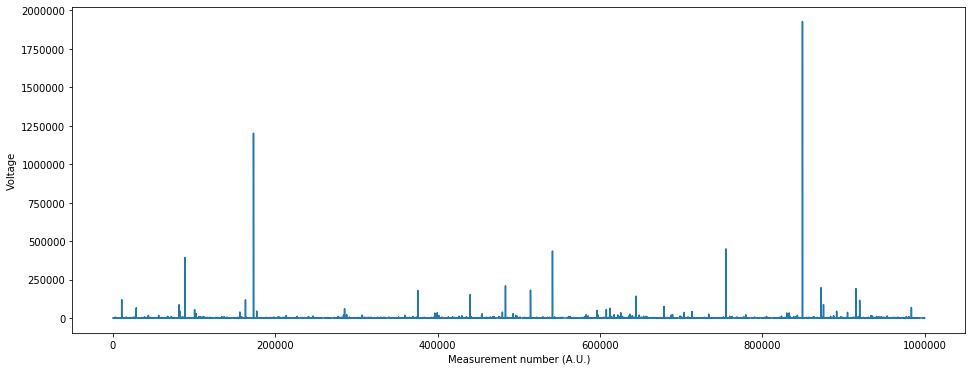

In [11]:
Nplot=len(voltage)
x=np.linspace(0,len(voltage[0:Nplot]),len(voltage[0:Nplot]))
fig, ax = plt.subplots(figsize=(16, 6));
ax.plot(x,voltage[0:Nplot],label="Raw data")
plt.xlabel("Measurement number (A.U.)")
plt.ylabel("Voltage")

We see a few peaks, but due to some of them being much higher than the rest, we dont really see a lot of detail. Lets try plotting the log of the data:

Text(0, 0.5, 'log(Voltage)')

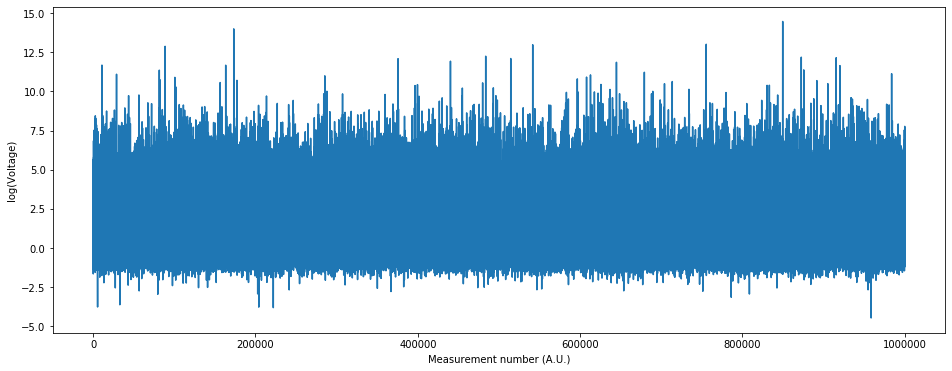

In [12]:
x=np.linspace(0,len(voltage[voltage>0]),len(voltage[voltage>0]))
fig2, ax2 = plt.subplots(figsize=(16, 6));
ax2.plot(x,np.log(voltage[voltage>0]))
plt.xlabel("Measurement number (A.U.)")
plt.ylabel("log(Voltage)")

We now see that indeed a lot of the data is dominated by noise, however we still se the peaks above something like $e^{9}$

Let us investigate the nature of the noise, by plotting the histogram of measurements:

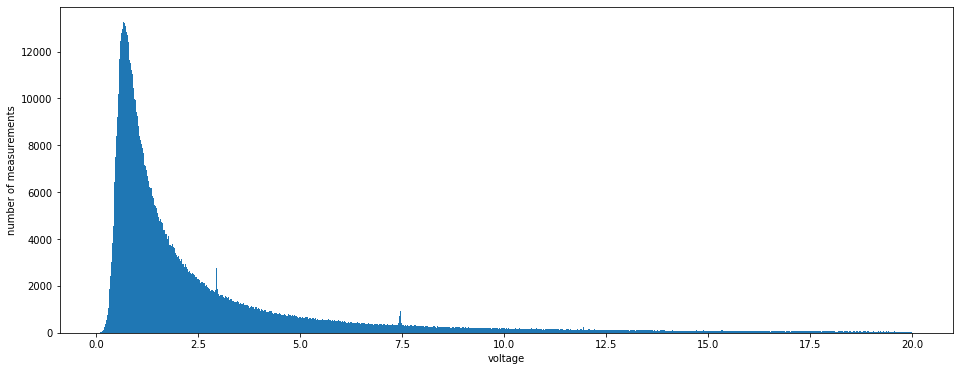

In [13]:
fig4, ax4 = plt.subplots(figsize=(16, 6));
counts,bin_edges,_=ax4.hist(voltage,bins=int(np.sqrt(len(voltage[voltage<20]))),range=(0.1,20))
plt.xlabel("voltage")
plt.ylabel("number of measurements")
plt.savefig("1_3_a1.png",dpi=600)

We see there is a long tail, our task will be to determine which parts of this are noise, and which are peaks. Lets plot on a log scale,so we can look at all the points:

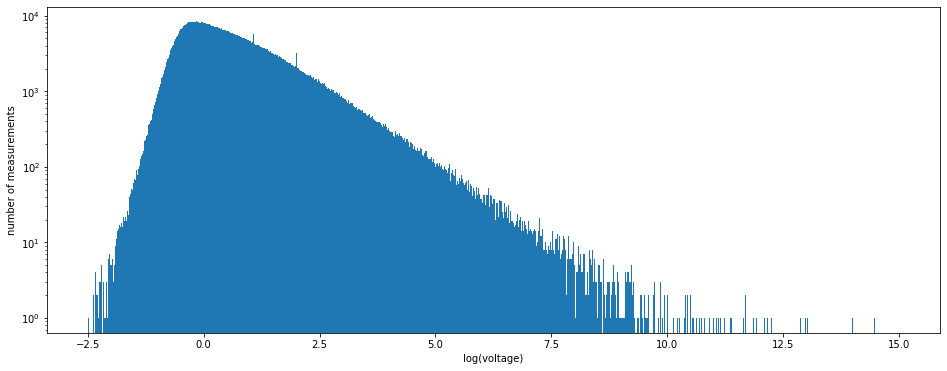

In [14]:
fig3, ax3 = plt.subplots(figsize=(16, 6));
Nbins=1000#int(np.sqrt(len(voltage)))
PlotData=np.log(voltage[voltage>0])
counts,bin_edges,_=ax3.hist(PlotData,bins=Nbins,range=(-2.5,15),log=True)
plt.xlabel("log(voltage)")
plt.ylabel("number of measurements")
plt.savefig("1_3_a2.png",dpi=600)

We see that in both above histrograms, there are rwo regularly spaced peaks. This could be consistent voltage peaks from measurements of the same particle. It could also be an artefact of incorrect binning of discrete data. Discrete data would make perfect sense for a digital instrument measuring voltages.

We could try to find the discreeteness by plotting with way to many bins, and counting the unique values. However the dataset is so large that my computer does not finish such a binning in a reasonable amount of time. Instead we shall look closely at the range where the peaks are suspected. If they are from incorrect binning, the change of range should eliminate them.


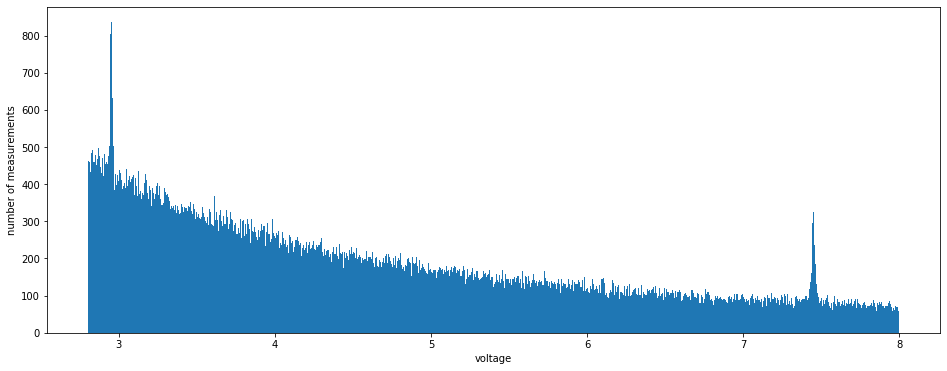

In [15]:
fig4, ax4 = plt.subplots(figsize=(16, 6));
_,_,_=ax4.hist(voltage,bins=1000,range=(2.8,8))
plt.xlabel("voltage")
plt.ylabel("number of measurements")
plt.savefig("1_3_a3.png",dpi=600)

We see that the two peaks persist, and that they are not confined to a single bin, if they arose from incorrect binning of discreete data, they would only be 1 bin wide. Thus we conclude that there is some signal, and proceed to investigate. 

Lets see if we can fit anything to the background, both to get something we can fit peaks on top of and to describe the tail of the distrubution (nedded for threshold).

Chi2 value: 12195.8   Ndof = 724    Prob(Chi2,Ndof) = 0.0


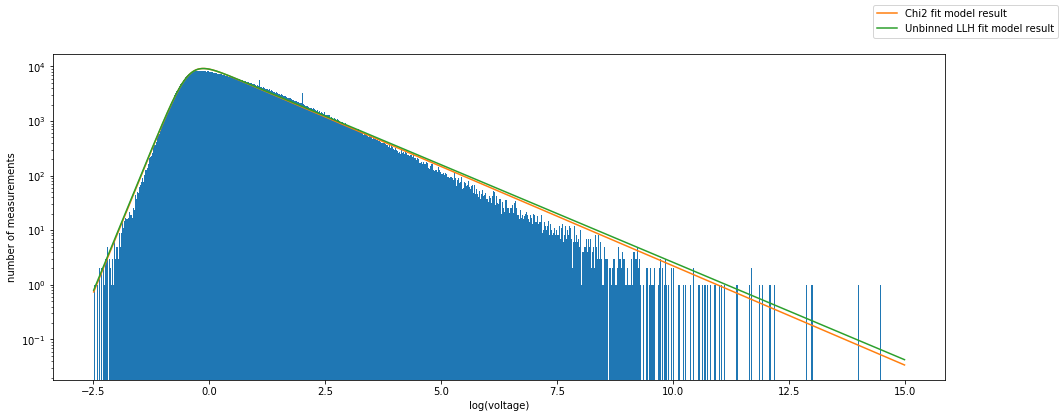

In [16]:
binwidth=bin_edges[1]-bin_edges[0]
def Double_Exp_fit_function(x, A, alpha, beta,x0): #define a function to fit with
    return A/(1+np.exp(-(x-x0)/alpha))*np.exp(-(x-x0)/beta)

e_counts=np.sqrt(counts) #square root-rules to get uncertainties

bin_values=(bin_edges[0:-1]+bin_edges[1::])/2

def chi2_Exp(A,alpha, beta, x0) :
    y_fit = Double_Exp_fit_function(bin_values[counts>0], A,alpha, beta,x0)
    chi2 = np.sum(((counts[counts>0] - y_fit) / e_counts[counts>0])**2)
    return chi2


chi2_Exp.errordef = 1.0    # Chi2 definition (for Minuit)

A_guess=12800
alpha_guess=0.16
beta_guess=1.3
x0_guess=-0.5

minuit = Minuit(chi2_Exp, A=A_guess, alpha=alpha_guess, beta=beta_guess, x0=x0_guess)
minuit.migrad()

alpha_fit = minuit.values['alpha']
beta_fit = minuit.values['beta']
A_fit = minuit.values['A']
x0_fit = minuit.values['x0']

x=np.linspace(bin_values[0],bin_values[-1],Nbins)
dx=x[1]-x[0]

ax3.plot(x,Double_Exp_fit_function(x, A_fit, alpha_fit,beta_fit,x0_fit),label='Chi2 fit model result')

chi2=minuit.fval
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - minuit.nfit

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

#lets try llh, as we have many empty bins;
ullhfit = UnbinnedLH(Double_Exp_fit_function, np.log(voltage[voltage>0]), bound=(x[0], x[-1]), extended=True)
minuit_ullh = Minuit(ullhfit, A=A_guess, alpha=alpha_guess, beta=beta_guess, x0=x0_guess)
minuit_ullh.errordef = 0.5     # Value for likelihood fits
minuit_ullh.migrad()           # Perform the actual fit

ax3.plot(x, Double_Exp_fit_function(x, *minuit_ullh.values[:])*dx, label='Unbinned LLH fit model result')
fig3.legend()
#Turns out to give almost same result.

fig3.savefig("1_3_a4.png",dpi=600)
fig3

Both from inspecting the figure and loking at the p-value, we see that this is not actually a good fit, but it looks to describe the general shape of the distribution reasonably well, so we could perhaps use it to try to determine a good threshold for which we say measurements above this probably do not belong to the background distribution. I suspected that the chisquare-fit ignoring the emty bins far to the right would make it slightly overestimate the height of the distribution in this region, however from the plot above we clearly see that the unbinned llh actually predicts a higher value than the chisquare in this region. We also see that both actually do not describe the tail very well. For both interpretations of the problem, we need a got fit to the background. So for the first interpretation I will make another fit only to the tail, and for the second a fit only in the region around the peaks we want to fit. 

We will start with the first interpretation:


Chi2 value: 408.6   Ndof = 447    Prob(Chi2,Ndof) = 0.9032172128929336


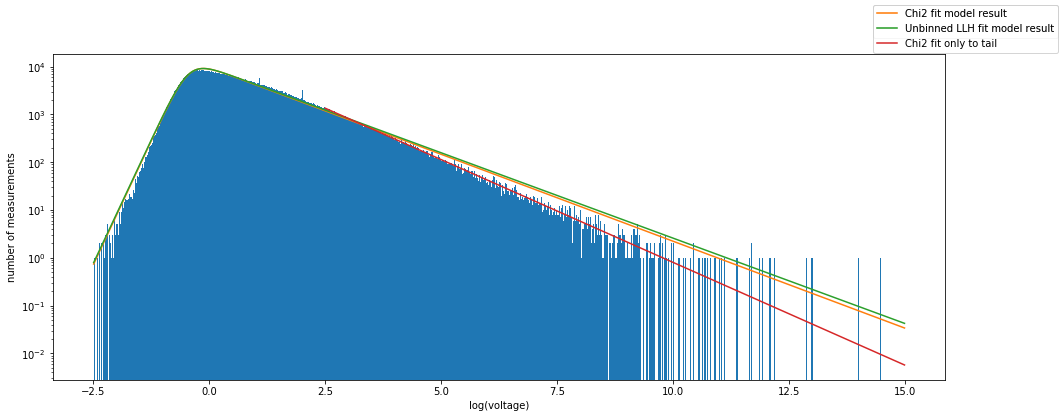

In [17]:
def Exp_fit_function(x, A, alpha,x0): #define a function to fit with
    return A*np.exp(-(x-x0)/alpha)

fitAbove=2.5 #fit only above this region
x_tail=bin_values[bin_values>fitAbove]
counts_tail=counts[bin_values>fitAbove]
countse_tail=np.sqrt(counts_tail)

def chi2_Exp(A,alpha, x0) :
    y_fit = Exp_fit_function(x_tail[counts_tail>0], A,alpha,x0)
    chi2 = np.sum(((counts_tail[counts_tail>0] - y_fit) / countse_tail[counts_tail>0])**2)
    return chi2

chi2_Exp.errordef = 1.0    # Chi2 definition (for Minuit)

#Initial guess:
A_guess=5000
alpha_guess=1.1
x0_guess=1

minuit = Minuit(chi2_Exp, A=A_guess, alpha=alpha_guess, x0=x0_guess)
minuit.migrad()

alpha_fit = minuit.values['alpha']
A_fit = minuit.values['A']
x0_fit = minuit.values['x0']

x=np.linspace(fitAbove,bin_values[-1],Nbins)
dx=x[1]-x[0]

ax3.plot(x,Exp_fit_function(x, A_fit, alpha_fit,x0_fit),label='Chi2 fit only to tail')
#ax3.plot(x,Exp_fit_function(x, A_guess, alpha_guess,x0_guess),label='guess')

chi2=minuit.fval
N_NotEmptyBin = np.sum(np.where(counts_tail > 0,1,0))
Ndof_value = N_NotEmptyBin - minuit.nfit

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")
fig3.legend()
fig3

This new fit is has a reasonable p-value, and describes the tail much better! Lets use this for determining our threshold.

I have chosen to pick 5% and higher chance that a value could be recorded given the backgorund to be when we disregard that point as a potential peak. 

We assume that each bin is governed by poisson statistics, and compute the probability that given the number of measurements in the tail in total and the expected number of points in each bin from the fit to the tail, that we should see any measurements in this bin. If this probability is below 5%, we say a signal is probably not part of the background.

12.786250000000003


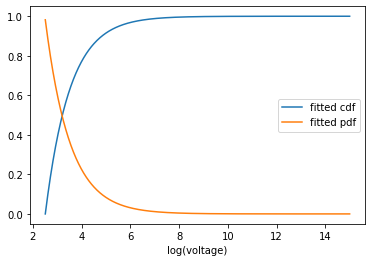

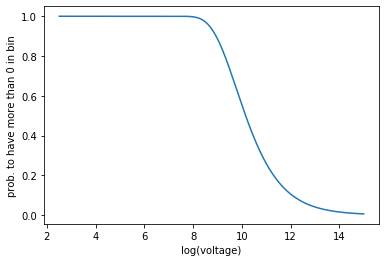

In [18]:
A=np.sum(Exp_fit_function(x_tail, *minuit.values[:]))*binwidth #normalize
pdf=Exp_fit_function(x_tail, *minuit.values[:])/A

cdf=np.array([np.sum(pdf[0:i]*binwidth) for i in range(len(pdf))])
plt.plot(x_tail,cdf,label="fitted cdf")
plt.plot(x_tail,pdf, label="fitted pdf")
plt.legend()
plt.xlabel("log(voltage)")

P=1-stats.poisson.pmf(0,pdf*binwidth*np.sum(counts_tail)) #probability go have more than 0 in this bin
plt.figure()
plt.plot(x_tail,P)
plt.xlabel("log(voltage)")
plt.ylabel("prob. to have more than 0 in bin")

candidates=x_tail[P<0.05] #threshold for 5% chance

t0=np.min(candidates) 
print(t0)

To round off the plotting part for interpretation 1, lets plot the raw data with the threshold for defining a peak:

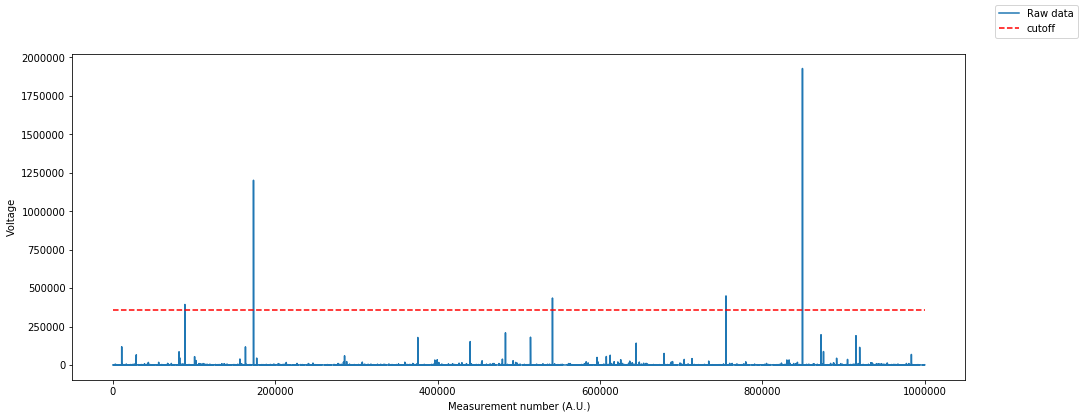

In [19]:
ax.plot([0,len(voltage)],[np.e**t0,np.e**t0],'--r',label="cutoff")
fig.legend()
fig

Now we close interpretatoin 1 by finally identifying peaks. The approach will be to look for locations where the voltage is over the threshold we found above.

Number of peaks: 5


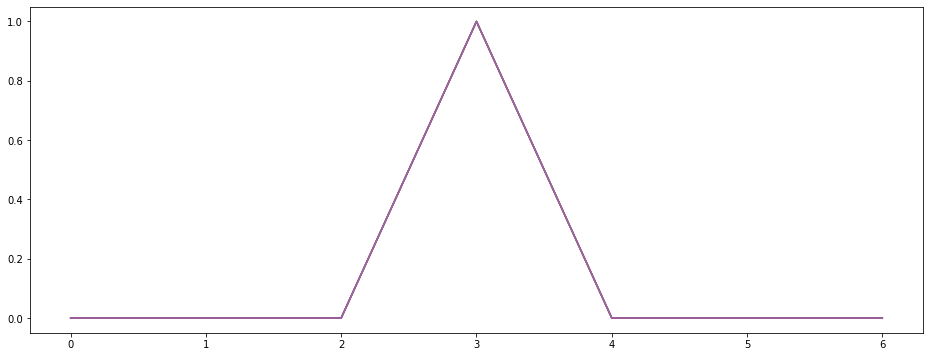

In [20]:
t=np.e**t0#transform to back to real-space instead of log-space

#Lets loop through possible locations

peakHeights=[]
peakXs=[]

Last_index=-1
peakHeight=-1
peakX=0
for i,v in enumerate(voltage):
    if v>t: # we are in peak
        if (i==(Last_index+1)): #We are in same peak
            if v>peakHeight:
                peakHeight=v
                peakX=i
        else: #different peak, save the last one
            if peakHeight>t:
                peakHeights.append(peakHeight)
                peakXs.append(peakX)
            peakHeight=v
            peakX=i
        Last_index=i # last time we were in peak
     

peakHeights.append(peakHeight) #catch last peak
peakXs.append(peakX)

#now lets plot ALL the peaks, to have a look at them

suround=3

fig5, ax5 = plt.subplots(figsize=(16, 6));

x_axis=np.arange(2*suround+1)

for i,Xi in enumerate(peakXs):
    ax5.plot(x_axis,voltage[Xi-suround:Xi+1+suround]/peakHeights[i])


print(f"Number of peaks: {len(peakHeights)}")

It looks to me like the peaks all have the same width (only 1 datapoint sticks above the backround), and thus the same shape. i.e. their only characteristic is their height, which we obtained without fitting. So to say anything about their characteristics I will simply print their heights and plot them i a histogram:

[ 393354.559266  435125.851854  448974.406522 1200752.731142
 1927359.118242]


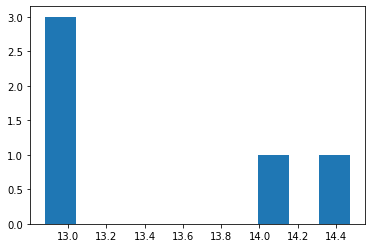

In [21]:
print(np.sort(peakHeights))
_=plt.hist(np.log(peakHeights))

It seems there are a couple of very high peaks comared to the rest, which are pretty close. You could perhaps identify 3 'species' of peaks, the two very large ones each as a species, and the three around 400000 as the last species. 

Now we return to close interpretation 2 (the one I suspect most correct) of the problem.

We identified two peaks in the histogram. We now want to fit them, and then combine all of our efforts in an epic plot. 

To start the fitting, lets plot and bin the data in the relevant region.

Step 1 is to get some good binning. Since I suspect the voltages are discreet, I will try to figure out their spacing by looking at a very narrow region in the histrogram where we have a lot of measurements, and bin them finely:

58.0


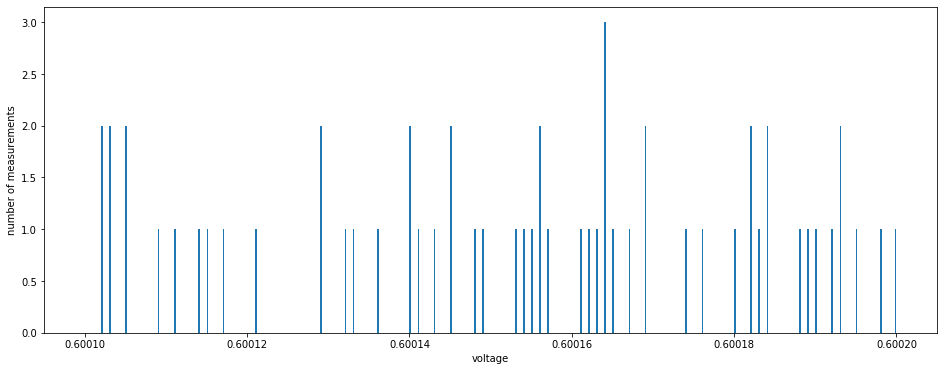

In [22]:
fig4, ax4 = plt.subplots(figsize=(16, 6));
counts,bin_edges,_=ax4.hist(voltage,bins=500,range=(0.6001,0.6002))
print(np.sum(counts))
plt.xlabel("voltage")
plt.ylabel("number of measurements")
plt.savefig("1_3_a5.png",dpi=600)

Indeed we see a regularity to their spacing, and bins where I suspect two measurements have exactly the same value. 
Lets calculate the gap between two of the peaks that look to be spaced by one quanta:

2.0
The spacing is: 9.97499999932927e-07


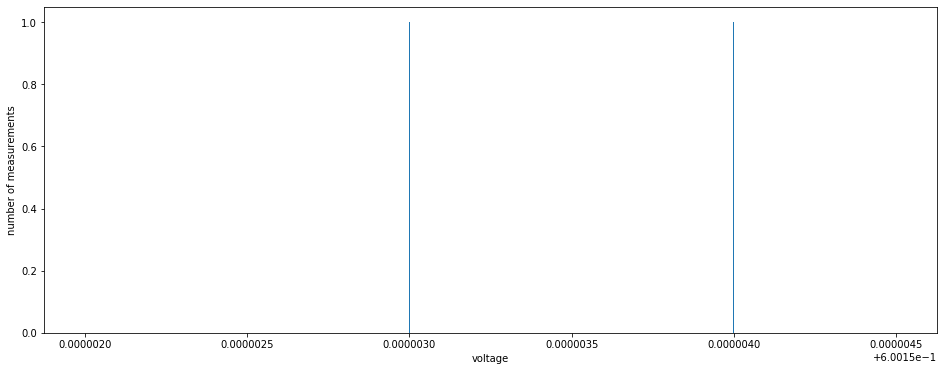

In [23]:
fig4, ax4 = plt.subplots(figsize=(16, 6));
counts,bin_edges,_=ax4.hist(voltage,bins=1000,range=(0.600152,0.6001545))
print(np.sum(counts))
plt.xlabel("voltage")
plt.ylabel("number of measurements")

bin_values=(bin_edges[1::]+bin_edges[0:-1])/2

spacing=bin_values[counts>0][1]-bin_values[counts>0][0]

print(f"The spacing is: {spacing}")
plt.savefig("1_3_a6.png",dpi=600)

So it seems the instrument used has a resolution of 1e-6V. This is so fine, that when we bin to observe the peaks, we do not need to worry about it, essentially treating the voltages as a continuous variable, since the peaks have a width orders of magnitude above the resolution of the instrument. 

With that in mind, we simply bick a binning that resolves the features nicely, leaves a reasonable number in each bin (at least 10) and has clean values for the binvalues:


2.505
Binwidth is 0.010 volt


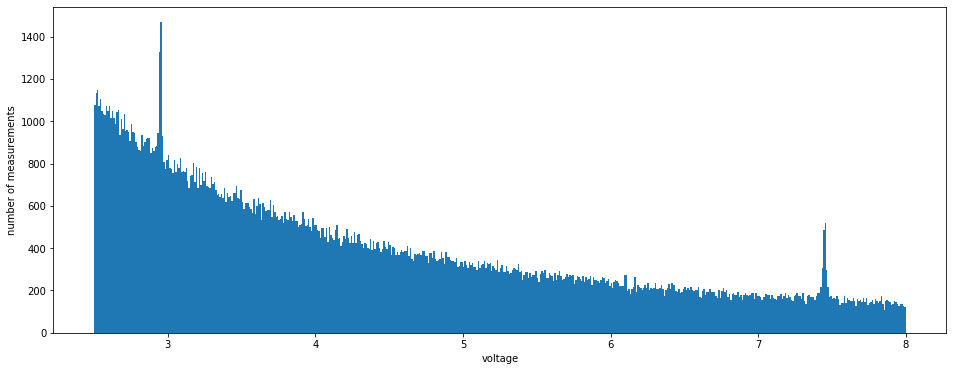

In [24]:
fig4, ax4 = plt.subplots(figsize=(16, 6));
counts,bin_edges,_=ax4.hist(voltage,bins=550,range=(2.5,8))
bin_values=(bin_edges[1::]+bin_edges[0:-1])/2
print(bin_values[0])
binwidth=(bin_values[1]-bin_values[0])
print(f"Binwidth is {binwidth:.3f} volt")
plt.xlabel("voltage")
plt.ylabel("number of measurements")
plt.savefig("1_3_a7.png",dpi=600)

We can now worry about fitting the peaks and a background. 
From the solution to interpretation 1, we know that an exponential describes the background well in this region.
I will fit the peaks with gaussians, as the width of the peaks should be given by the probably gaussian error on the instrument. (In a perfect world the instrument would always give the same voltage for some paricle, and thus the peaks would be delta-functions). We will fit with the same peakwidth for both peaks, as this should be dependent on the instrument, not the particle.


Chi2 value: 622.7   Ndof = 541.00000    Prob(Chi2,Ndof) = 0.008444423931781136
Chi2 value: 1684.0   Ndof = 541.00000    Prob(Chi2,Ndof) = 1.804364799664477e-117


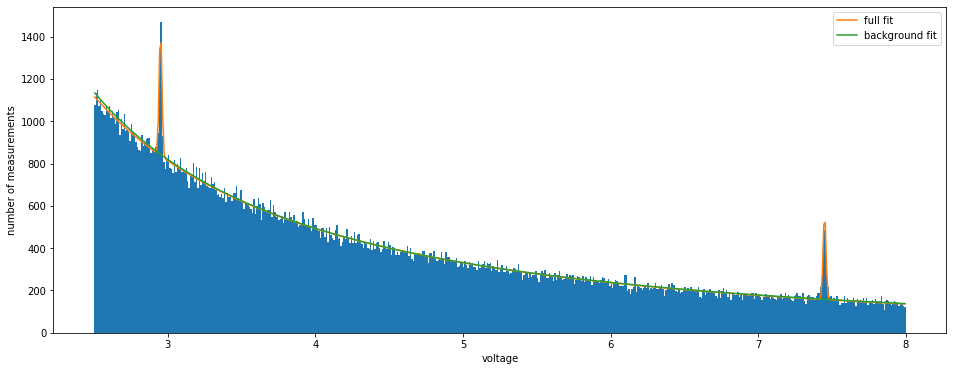

Peakheigths are: 14.37 +- 0.70 and 9.99 +- 0.45
Locations are are: 2.95065 +- 0.00051 and 7.45028 +- 0.00054
Width of peaks is: 0.00966 +- 0.00037


In [25]:
#We define sume functions to fit with:
def Exp_fit_function(x, B, alpha, x0, beta): #background
    return B*np.exp(-np.abs(x-x0)**(beta)/alpha)

def Gaussian_fit_function(x, A, mu, sig): #peak
    return A*np.exp(-(x-mu)**2/(2*sig**2))/(sig*np.sqrt(2*np.pi))

def Combined_fit(x, B, alpha, x0, beta, A1, A2, mu1, mu2, sig): #background and two peaks
    return Exp_fit_function(x, B, alpha, x0, beta) + Gaussian_fit_function(x, A1, mu1, sig) +Gaussian_fit_function(x, A2, mu2, sig)

def chi2(B,x0,alpha,beta,A1,A2,mu1,mu2,sig):
    y_fit=Combined_fit(bin_values, B, alpha, x0, beta, A1, A2, mu1, mu2, sig)
    return np.sum(((counts-y_fit)/np.sqrt(counts))**2)

def chi2_background(B, alpha, x0, beta):
    y_fit=Exp_fit_function(bin_values, B, alpha, x0, beta)
    return np.sum(((counts-y_fit)/np.sqrt(counts))**2)

def printProb(chisquare,NDOF):
    Prob_value = stats.chi2.sf(chisquare, NDOF) # The chi2 probability given N_DOF degrees of freedom
    print(f"Chi2 value: {chisquare:.1f}   Ndof = {NDOF:.5f}    Prob(Chi2,Ndof) = {Prob_value}")
    

chi2.errordef = 1.0    # Chi2 definition (for Minuit)
chi2_background.errordef = 1.0    # Chi2 definition (for Minuit)

#Initial guess:
B_guess=12000
alpha_guess=0.5
x0_guess=1.4
beta_Guess=0.4
A1_guess=10
A2_guess=10
mu1_guess=2.95
mu2_guess=7.45
sig_guess=0.01

#minimize:
minuit = Minuit(chi2, B=B_guess,alpha=alpha_guess,x0=x0_guess,beta=beta_guess,A1=A1_guess,A2=A2_guess,mu1=mu1_guess,mu2=mu2_guess,sig=sig_guess)
minuit.migrad()

#plot:
ax4.plot(bin_values,Combined_fit(bin_values,B=minuit.values['B'],alpha=minuit.values['alpha'],x0=minuit.values['x0'],beta=minuit.values['beta'],A1=minuit.values['A1'],A2=minuit.values['A2'],mu1=minuit.values['mu1'],mu2=minuit.values['mu2'],sig=minuit.values['sig']),label='full fit')
#ax4.plot(bin_values,Combined_fit(bin_values,B=B_guess,alpha=alpha_guess,x0=x0_guess,beta=beta_guess,A1=A1_guess,A2=A2_guess,mu1=mu1_guess,mu2=mu2_guess,sig=sig_guess),label='full fit guess')

#get prob.:
chi2=minuit.fval
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - minuit.nfit
printProb(chi2,Ndof_value)


#background only:
minuit_background=Minuit(chi2_background, B=B_guess,alpha=alpha_guess,x0=x0_guess,beta=beta_guess)
minuit_background.migrad()
#ax4.plot(bin_values,Exp_fit_function(bin_values,B=B_guess,x0=x0_guess,alpha=alpha_guess,beta=beta_guess),label='background fit guess')
ax4.plot(bin_values,Exp_fit_function(bin_values,*minuit_background.values[:]),label='background fit')
chi2_background=minuit_background.fval
printProb(chi2_background,Ndof_value)

ax4.legend()
display(fig4)
fig4.savefig("1_3_a8.png",dpi=600)

print(f"Peakheigths are: {minuit.values['A1']:.2f} +- {minuit.errors['A1']:.2f} and {minuit.values['A2']:.2f} +- {minuit.errors['A2']:.2f}")
print(f"Locations are are: {minuit.values['mu1']:.5f} +- {minuit.errors['mu1']:.5f} and {minuit.values['mu2']:.5f} +- {minuit.errors['mu2']:.5f}")
print(f"Width of peaks is: {minuit.values['sig']:.5f} +- {minuit.errors['sig']:.5f}")

The background is not truly exponential in this region, but adding a power beta such that the exponential now contained $(x-x_0)^\beta$ instead of $(x-x_0)$ with beta smaller than 1 the fit was improved, as the tail falls off slower than an expoential. The p-value is still very small, perhaps it could be increased by fitting with different widths of the peaks:

Chi2 value: 586.8   Ndof = 540.00000    Prob(Chi2,Ndof) = 0.079900164473757


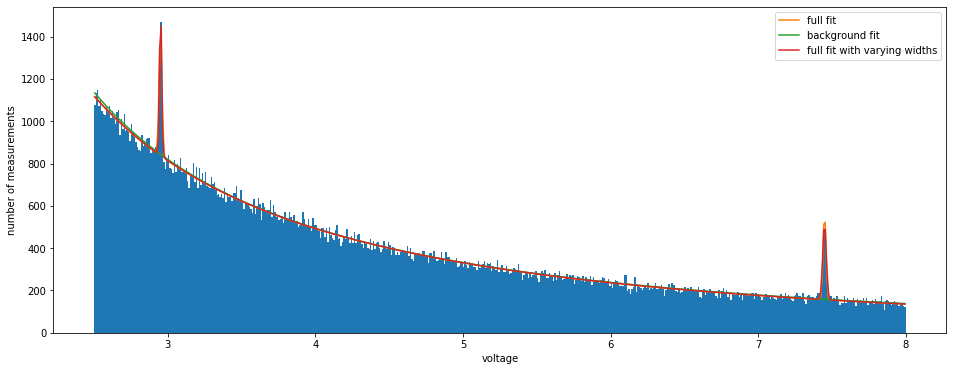

Peakheigths are: 13.08 +- 0.71 and 10.93 +- 0.48
Locations are are: 2.95105 +- 0.00044 and 7.45010 +- 0.00058
Widths of peaks are: 0.00733 +- 0.00050 and 0.01208 +- 0.00066


In [26]:
def Combined_fit(x, B, alpha, x0, beta, A1, A2, mu1, mu2, sig1, sig2): #background and two peaks
    return Exp_fit_function(x, B, alpha, x0, beta) + Gaussian_fit_function(x, A1, mu1, sig1) +Gaussian_fit_function(x, A2, mu2, sig2)

def chi2(B,x0,alpha,beta,A1,A2,mu1,mu2,sig1,sig2):
    y_fit=Combined_fit(bin_values, B, alpha, x0, beta, A1, A2, mu1, mu2, sig1,sig2)
    return np.sum(((counts-y_fit)/np.sqrt(counts))**2)


chi2.errordef = 1.0    # Chi2 definition (for Minuit)

#minimize:
minuit = Minuit(chi2, B=B_guess,alpha=alpha_guess,x0=x0_guess,beta=beta_guess,A1=A1_guess,A2=A2_guess,mu1=mu1_guess,mu2=mu2_guess,sig1=sig_guess,sig2=sig_guess)
minuit.migrad()

#plot:
ax4.plot(bin_values,Combined_fit(bin_values,B=minuit.values['B'],alpha=minuit.values['alpha'],x0=minuit.values['x0'],beta=minuit.values['beta'],A1=minuit.values['A1'],A2=minuit.values['A2'],mu1=minuit.values['mu1'],mu2=minuit.values['mu2'],sig1=minuit.values['sig1'],sig2=minuit.values['sig2']),label='full fit with varying widths')

#get prob.:
chi2=minuit.fval
Ndof_value = N_NotEmptyBin - minuit.nfit
printProb(chi2,Ndof_value)

ax4.legend()
display(fig4)
fig4.savefig("1_3_a9.png",dpi=600)

print(f"Peakheigths are: {minuit.values['A1']:.2f} +- {minuit.errors['A1']:.2f} and {minuit.values['A2']:.2f} +- {minuit.errors['A2']:.2f}")
print(f"Locations are are: {minuit.values['mu1']:.5f} +- {minuit.errors['mu1']:.5f} and {minuit.values['mu2']:.5f} +- {minuit.errors['mu2']:.5f}")
print(f"Widths of peaks are: {minuit.values['sig1']:.5f} +- {minuit.errors['sig1']:.5f} and {minuit.values['sig2']:.5f} +- {minuit.errors['sig2']:.5f}")

The p-value increased by a factor of 10, and is now in the generally accepted range. 

It seems the peaks actually have significantly different widths, this is strange as one would expect the width to be determined by the instrument.

The heights of the peaks correspond to the number of events, to convert we simply need to divide by the binwidth.
We observed more events in the 3V peak than in the 7.5V peak. (ca. 1300 and 1100)

The locations we are told correspond to masses, but without the relationship the peak-locations dont contain any real information, other than the fact that there are two distinct peaks.

We now only have to combine it all in a plot.

Behold:

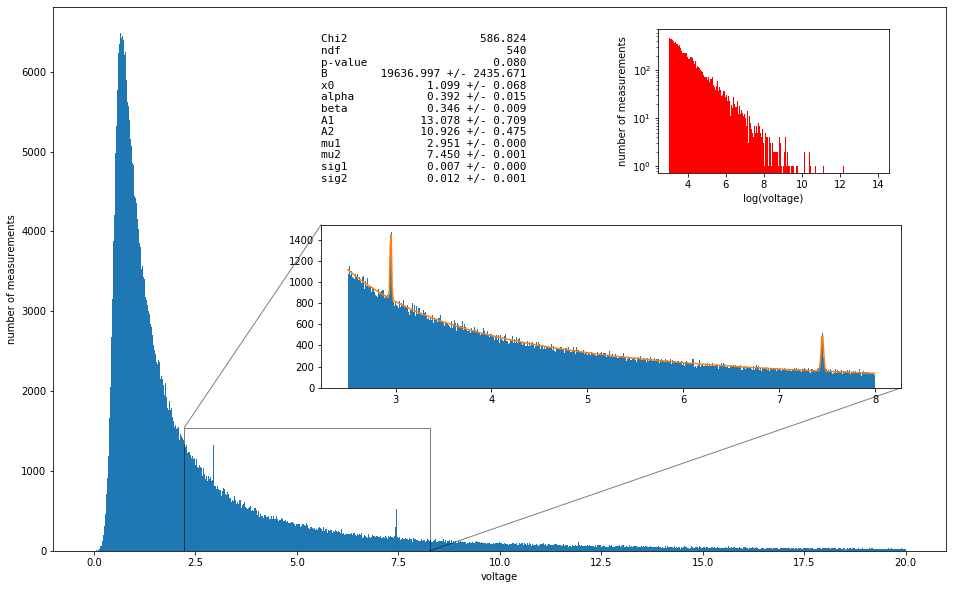

In [27]:
#main figure:
fig4, ax4 = plt.subplots(figsize=(16, 10));
handoff=20
counts,bin_edges,_=ax4.hist(voltage,bins=100*handoff,range=(0,handoff))
plt.xlabel("voltage")
plt.ylabel("number of measurements")

#handoff insert:
plt.axes([.65, .65, .2, .2])
_=plt.hist(np.log(voltage[voltage>handoff]),range=(np.log(handoff),14),bins=1000,color='r',log=True)
plt.xlabel("log(voltage)")
plt.ylabel("number of measurements")

#fit insert:
axins=ax4.inset_axes([.3, .3, .65, .3])
_=axins.hist(voltage,bins=550,range=(2.5,8))
axins.plot(bin_values,Combined_fit(bin_values,B=minuit.values['B'],alpha=minuit.values['alpha'],x0=minuit.values['x0'],beta=minuit.values['beta'],A1=minuit.values['A1'],A2=minuit.values['A2'],mu1=minuit.values['mu1'],mu2=minuit.values['mu2'],sig1=minuit.values['sig1'],sig2=minuit.values['sig2']),label='full fit with varying widths')
ax4.indicate_inset_zoom(axins,edgecolor='black')

d = {'Chi2':     chi2,
     'ndf':      Ndof_value,
     'p-value':  stats.chi2.sf(chi2, Ndof_value)
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.3, 0.95, text, ax4, fontsize=11)


plt.savefig("1_3_a10.png",dpi=600)


### Problem 2

#### 2.1
##### a)
We are asked to perform error-propagation on two functions of a single variable x. The functions are:

$y(x)=\frac{1}{1+x^2}$

And

$z(x)=\frac{1}{(1-x)^2}$

We will follow two approaches, one analytical, assuming the error propgation formula holds, and one numerical, since simulation is easy, and we might as well do it. 

Starting with the analytical, we define the funtions in sympy(Since we are to lazy to do it by hand):


In [28]:
x,y,z = symbols("x,y,z")
dx,dy,dz = symbols("sigma_x, sigma_y, sigma_z")

y=1/(1+x**2)

z=1/(x-1)**2

We can now do the error-propagation using the nice funtion we defined earlier. This funtion simply implements the error-propagation formula, and returns an expression for the propagated error, in terms of the covariance matrix.

In [29]:

dy,Vy=AnalyticalErrorProp(y) #Let sympy do the derivatives
dz,Vz=AnalyticalErrorProp(z)
V=Matrix([[dx**2]]) #Our 1D covariance matrix

dy=dy.subs({Vy:V})[0,0]*1 #Substitute in the covariance matrix
dz=dz.subs({Vz:V})[0,0]*1

fdy=lambdify((x,dx),dy) #lambdify to make funtion we can do numerical calculations with
fdz=lambdify((x,dx),dz)
fy=lambdify((x),y)
fz=lambdify((x),z)

#Define the point of interest:
x_value=1.96
dx_value=0.03

print(f"The value of the function y is: {fy(x_value):.3f} +- {fdy(x_value,dx_value):.3f}")
print(f"The value of the function z is: {fz(x_value):.3f} +- {fdz(x_value,dx_value):.3f}")

#Print analytical expressions, just for fun:

lprint(latex(Eq(symbols('sigma_y'), dy)))
lprint(latex(Eq(symbols('sigma_z'), dz)))

The value of the function y is: 0.207 +- 0.005
The value of the function z is: 1.085 +- 0.068


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

We now move on to the numerical approach. For this we pick 100000 numbers from a gaussian distribution with mean 0 and std matching the error on x. We now compute y(x+random numbers) and plot the resulting ditribution. We then calculate the std of this distribution and report this as the propagated error, provided that the distrubution is reasonably gaussian. 

The value of the function y is: 0.207 +- 0.030
The value of the function z is: 1.085 +- 0.575


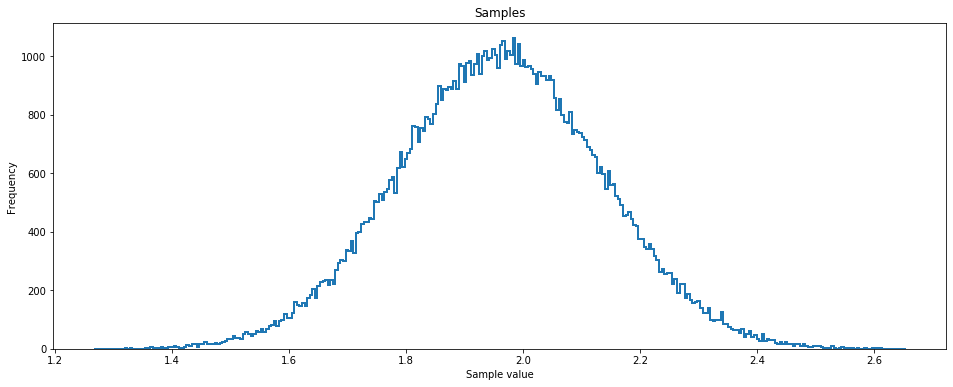

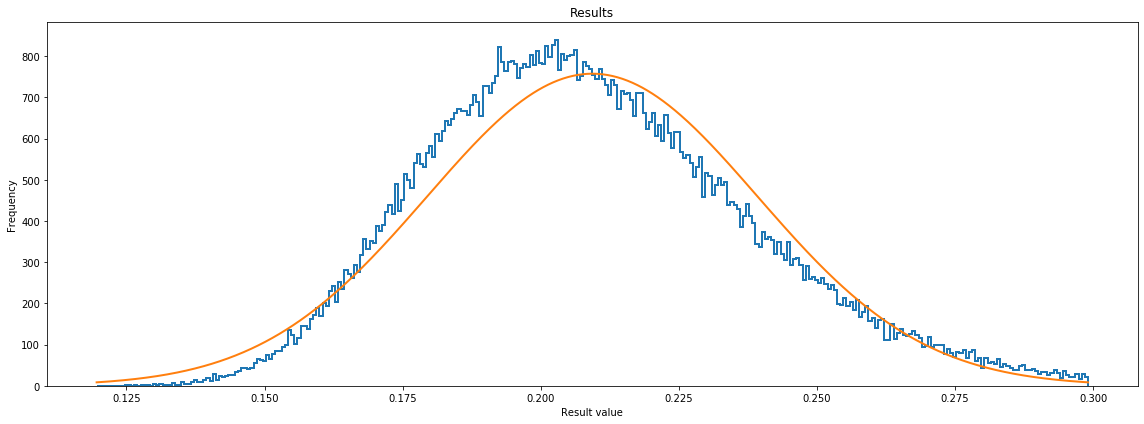

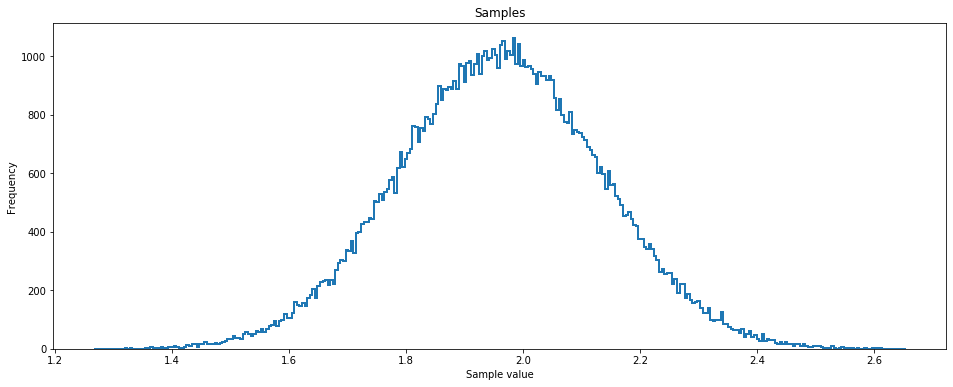

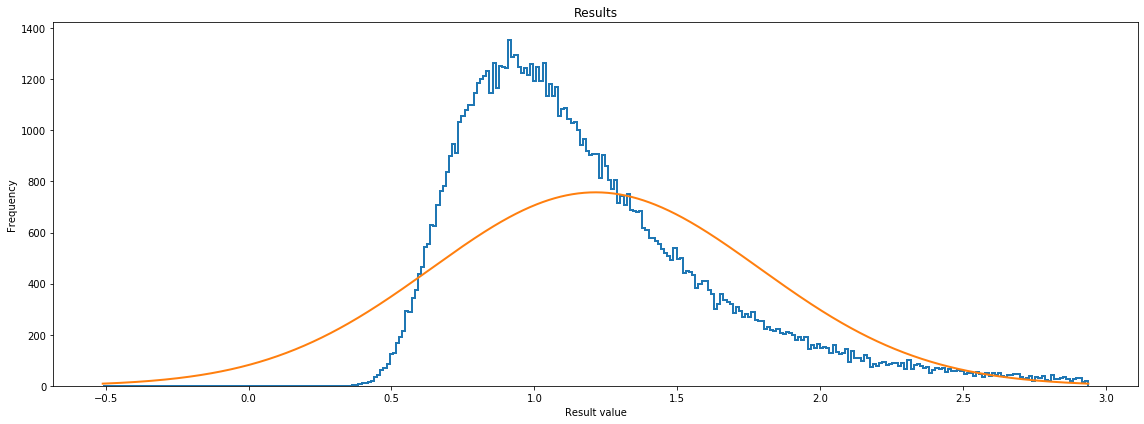

In [30]:
def Y(x):
    return 1/(1+x[0]**2)
def Z(x):
    return 1/(1-x[0])**2

x_value=1.96
dx_value=0.03

N_draw=100000

dY,Y_samples,_=NumericalErrorPropagation(Y,np.array([[dx_value]]),np.array([x_value]),N=N_draw,verbose=False,plotting=True,filename="2_1_a1.png")
dZ,Z_samples,_=NumericalErrorPropagation(Z,np.array([[dx_value]]),np.array([x_value]),N=N_draw,verbose=False,plotting=True,filename="2_1_a2.png")

print(f"The value of the function y is: {Y(np.array([x_value])):.3f} +- {dY:.3f}")
print(f"The value of the function z is: {Z(np.array([x_value])):.3f} +- {dZ:.3f}")

We see that the resulting distribution for y(x) is reasonably gaussian. However there is some skew towards higher values, suggesting that the approximatian that the slope of y is constant over the range of $\sigma_x$ is not valid. However I would still say its fair to report the error as gaussian. Interestingly the std computed from the resulting distribution is slightly larger than the analytical value. I suspect this is from the fact that the resulting distribution is not really gaussian, and in the end report the uncertainty obtained from the numerical approach. 

For z(x) we see that the gaussian approximation does not hold. Had we not done the numerical approach, we would not have realised this - simulation really is a game-changer! The distribution looks very asymetrical, however we still have hope that the errors might be gaussian, so we will now proceed to fit a half gaussian to each side, in order to obtain two errors. 


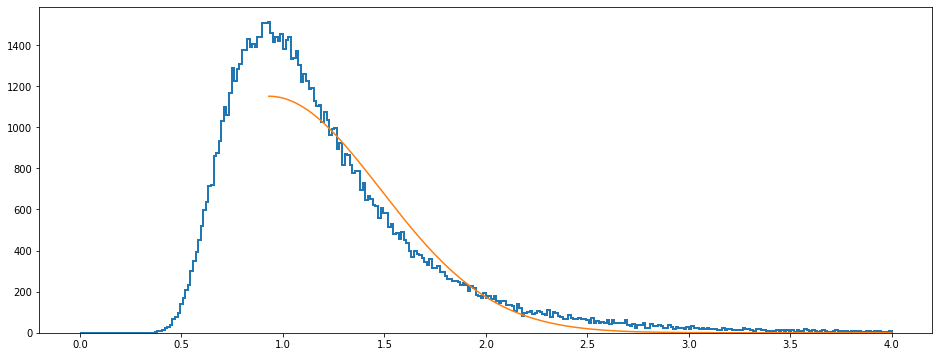

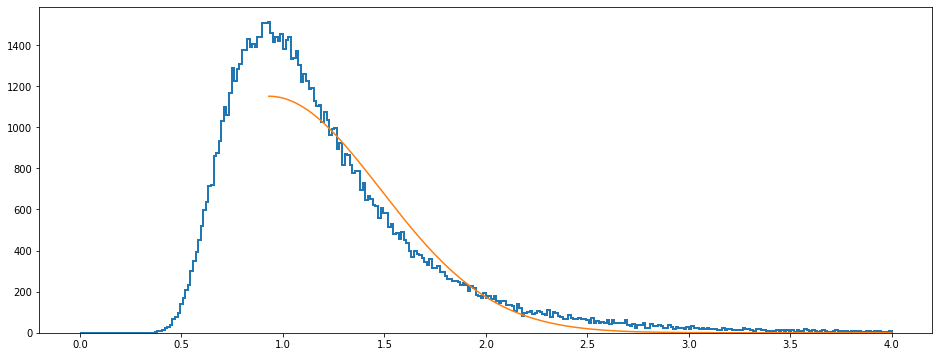

In [31]:
def Gaussian_fit_function(x, mu, A, sig): #define a gaussian to fit
    return A*np.exp(-0.5*((x-mu)/sig)**2)/(sig*np.sqrt(2*np.pi))


xmin, xmax = 0.0,4.0
figZ, axZ = plt.subplots(figsize=(16, 6));
Z_dist,bin_edges, _ = axZ.hist(Z_samples, int(np.sqrt(N_draw)), range=(xmin, xmax), histtype='step', linewidth=2)
e_Z_dist=np.sqrt(Z_dist) #square root-rules to get uncertainties

bin_values=bin_edges[0:-1]+(xmax-xmin)/(2*int(np.sqrt(N_draw)))

Z_dist_plus=Z_dist[np.argmax(Z_dist)::]
bin_values_plus=bin_values[np.argmax(Z_dist)::]
e_Z_dist_plus=e_Z_dist[np.argmax(Z_dist)::]

mu=bin_values[np.argmax(Z_dist)]

def chi2_Gaussian_plus(A, sig) :
    y_fit = Gaussian_fit_function(bin_values_plus, mu, A, sig)
    chi2 = np.sum(((Z_dist_plus - y_fit) / e_Z_dist_plus)**2)
    return chi2

chi2_Gaussian_plus.errordef = 1.0    # Chi2 definition (for Minuit)

minuit_plus = Minuit(chi2_Gaussian_plus, A=np.max(Z_dist), sig=dZ)
minuit_plus.migrad()

sig_fit = minuit_plus.values['sig']
A_fit = minuit_plus.values['A']

x=np.linspace(bin_values_plus[0],xmax,1000)

axZ.plot(x,Gaussian_fit_function(x, mu, A_fit, sig_fit))
figZ.savefig("2_1_a3.png",dpi=600)
figZ

This fit does not feel very satisfying, so lets instead approach the problem anther way. We will compute the confidence intervals corresponding to one sigma $\approx \pm 34.1 \%$ around the most probable value, and use these as the errors. We will require that half is above and half is below center of interval, and a central interval.

z(x) is 1.095 + 0.519 - 0.304


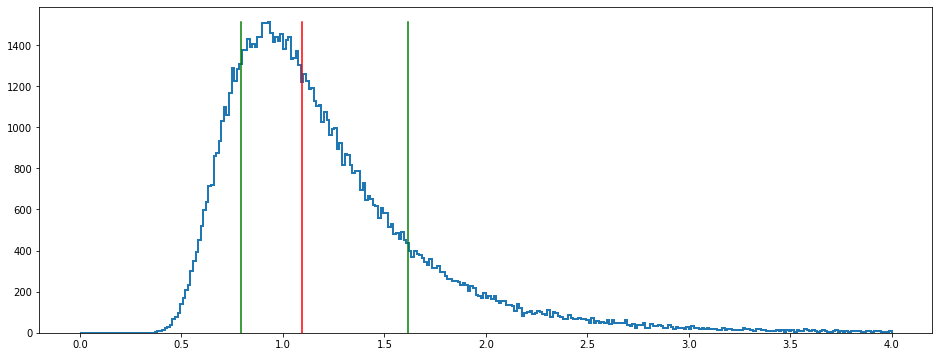

In [32]:
def GetPercentile(x,percentile):
    N=np.sum(x) #Total amount
    x_normed=x/N #Normalize
    cdf=[np.sum(x_normed[0:i]) for i in range(len(x))]
    
    for i,c in enumerate(cdf):
        if c>=percentile:
            return i
    return 0

xmin, xmax = 0.0,4.0
figP, axP = plt.subplots(figsize=(16, 6));
Z_dist,bin_edges, _ = axP.hist(Z_samples, int(np.sqrt(N_draw)), range=(xmin, xmax), histtype='step', linewidth=2)
e_Z_dist=np.sqrt(Z_dist) #square root-rules to get uncertainties

bin_values=bin_edges[0:-1]+(xmax-xmin)/(2*int(np.sqrt(N_draw)))

lower=GetPercentile(Z_dist,0.5-0.341)
mid=GetPercentile(Z_dist,0.5)
higher=GetPercentile(Z_dist,0.5+0.341)

Z_value=bin_values[mid]
Z_plus=bin_values[higher]-bin_values[mid]
Z_minus=bin_values[mid]-bin_values[lower]

axP.plot([Z_value,Z_value],[0,np.max(Z_dist)],'-r')
axP.plot([Z_value+Z_plus,Z_value+Z_plus],[0,np.max(Z_dist)],'-g')
axP.plot([Z_value-Z_minus,Z_value-Z_minus],[0,np.max(Z_dist)],'-g')
figP
print(f"z(x) is {Z_value:.3f} + {Z_plus:.3f} - {Z_minus:.3f}")
figP.savefig("2_1_a4.png",dpi=600)


So we report z(x) as $z(1.96) = 1.095 + 0.5 - 0.3$ And emphasisig that the errors are obtained by integrating uncer the achieved distibution, and perhaps including the simulated dsitribution in an appendix. 

##### b)
We are now asked to use a different value of x. Already we should notice that we should be carefull, as z(x) is singular at x=1, and the new point is very close

First we e simply carry out the analytical approach again:

In [33]:
#Define the point of interest:
x_value=0.96
dx_value=0.03

print(f"The value of the function y is: {fy(x_value):.3f} +- {fdy(x_value,dx_value):.3f}")
print(f"The value of the function z is: {fz(x_value):.3f} +- {fdz(x_value,dx_value):.3f}")

The value of the function y is: 0.520 +- 0.016
The value of the function z is: 625.000 +- 937.500


We see a huge change for the funtion z, as it has a singularity at x=1. The numerical version of the solutions will perhaps tell us if our formula breaks down spectacularly in this region. We simply repeat our solutions from before:

The value of the function y is: 0.520 +- 0.090
The value of the function z is: 625.000 +- 593757672.024


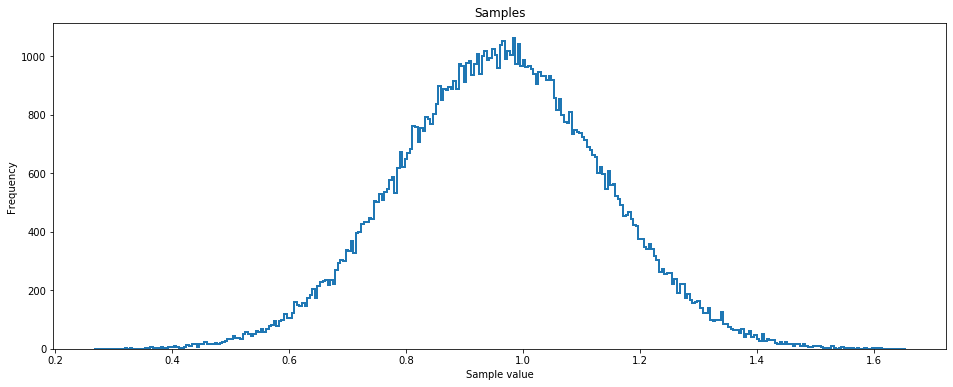

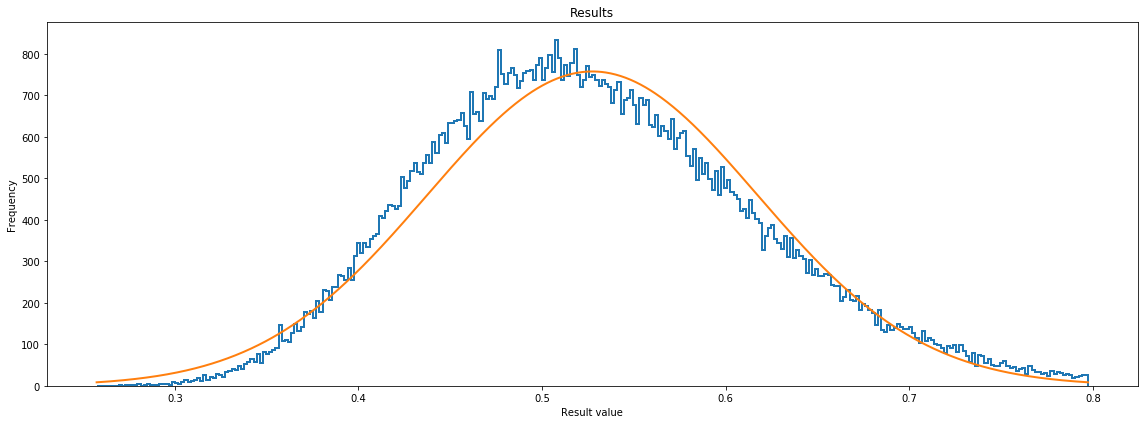

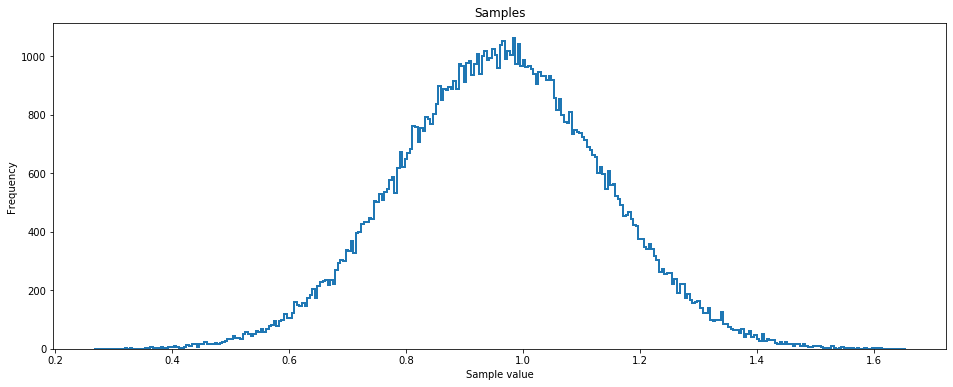

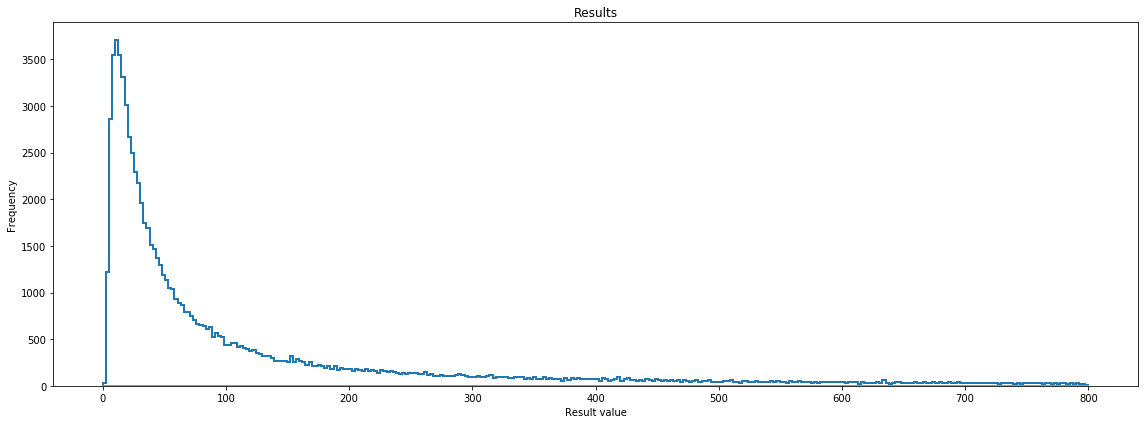

In [34]:
N_draw=100000

dY,Y_samples,_=NumericalErrorPropagation(Y,np.array([[dx_value]]),np.array([x_value]),N=N_draw,verbose=False,plotting=True,filename="2_1_b1.png")
dZ,Z_samples,X_samples=NumericalErrorPropagation(Z,np.array([[dx_value]]),np.array([x_value]),N=N_draw,verbose=False,plotting=True,plotRange=[0,800],filename="2_1_b2.png")

print(f"The value of the function y is: {Y(np.array([x_value])):.3f} +- {dY:.3f}")
print(f"The value of the function z is: {Z(np.array([x_value])):.3f} +- {dZ:.3f}")

For y(x) we see that the output distribution is reasonably gaussian, so we are satisfied to report the values obtained from the gaussian in the numerical approach. 

For z(x) the gaussian comuted from the sample mean and RMS is completely off. The distribution of the output is celarly not gaussian, and not even centered on z(x_value). There are also parts of the dsitrubution extending to very high values. These result from the gaussian noise giving a point essentially at x=1. 

For example lets print the maximum value we simulated:

In [35]:
print(f"Max has a value of: {np.max(Z_samples):.3f} and was generated from x={X_samples[np.argmax(Z_samples)][0]:.8f}")

Max has a value of: 187210567540.638 and was generated from x=0.99999769


These few outliers dominate the RMS computation. Let us instead use the interval-approach from before:

z(x) is 52.215 + 202.532 - 34.810


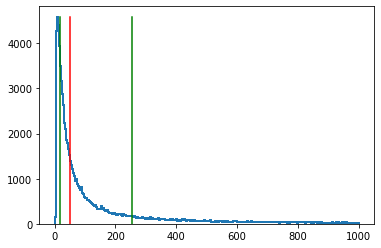

In [36]:
xmin, xmax = 0.0,1000
Z_dist,bin_edges, _ = plt.hist(Z_samples, int(np.sqrt(N_draw)), range=(xmin, xmax), histtype='step', linewidth=2)
e_Z_dist=np.sqrt(Z_dist) #square root-rules to get uncertainties

bin_values=bin_edges[0:-1]+(xmax-xmin)/(2*int(np.sqrt(N_draw)))


lower=GetPercentile(Z_dist,0.5-0.341)
mid=GetPercentile(Z_dist,0.5)
higher=GetPercentile(Z_dist,0.5+0.341)

Z_value=bin_values[mid]
Z_plus=bin_values[higher]-bin_values[mid]
Z_minus=bin_values[mid]-bin_values[lower]

plt.plot([Z_value,Z_value],[0,np.max(Z_dist)],'-r')
plt.plot([Z_value+Z_plus,Z_value+Z_plus],[0,np.max(Z_dist)],'-g')
plt.plot([Z_value-Z_minus,Z_value-Z_minus],[0,np.max(Z_dist)],'-g')


print(f"z(x) is {Z_value:.3f} + {Z_plus:.3f} - {Z_minus:.3f}")

plt.savefig("2_1_b3.png",dpi=600)

For the above computation we discarded all z-values above 1000. This skews the results dramatically. However, if we include all the z-values we would have to use something like $10^{12}$ (on the order of max(Z_samples)) bins for the computation to make sense, i.e. for the numerical integration to be fine enough. 

In the end I would probably report the above computation as my result, if I had to give some numbers. However it is probably best to report that the 
value of z(x) is not well defined given x=0.96 as the (gaussian) uncertainty of 0.03 on x means that we are within 2 sigma of the singularity.

What a nasty error-propagation!


#### 2.2

##### a)
Now for something completely different. We are given a table of results for measurements of g and their uncertainties. lets define them:

In [37]:
g=np.array([9.54,9.36,10.02,9.87,9.98,9.86,9.86,9.81,9.79])
g_sig=np.array([0.15,0.10,0.11,0.08,0.14,0.06,0.03,0.13,0.04])

Assuming they are all independent, we can simply combine them in a weighted average:

In [38]:
weights=(1/g_sig**2)/np.sum(1/g_sig**2)
g_average=np.average(g,weights=weights)
g_average_sig=np.sqrt(np.sum(weights**2*g_sig**2))

print(f"Weighted average is: {g_average:.3f} +- {g_average_sig:.3f}")

Weighted average is: 9.824 +- 0.020


##### b)
Now we actually pause (as we always should when combining meaurements) to check if the values we used in the average are actually compatible. For this we compute the chisquare and the p-value, to see if the 'fit' of a constant function is actually good. 

In [39]:
chi2=np.sum((g-g_average)**2/g_sig**2)
chi2_prob = stats.chi2.sf(chi2,len(g)-1) #used one degree of freedom in 'fit'

print(f"The chisquare is {chi2:.3f} which gives a p-value of {chi2_prob}")


The chisquare is 32.396 which gives a p-value of 7.910771701645516e-05


This p-value is small enough that we should suspect at least one measurement to not be compatible with the rest. To check wich it is, lets exlude all the points one by one, and see if the p-value increases:


In [40]:
for i in range(len(g)):
    g_i=np.concatenate([g[0:i],g[i+1::]])
    g_sig_i=np.concatenate([g_sig[0:i],g_sig[i+1::]])

    weights_i=(1/g_sig_i**2)/np.sum(1/g_sig_i**2)
    g_average_i=np.average(g_i,weights=weights_i)
    g_average_sig_i=np.sqrt(np.sum(weights_i**2*g_sig_i**2))
    
    chi2=np.sum((g_i-g_average_i)**2/g_sig_i**2)
    chi2_prob = stats.chi2.sf(chi2,len(g)-1) #used one degree of freedom in 'fit'

    print(f"The chisquare is {chi2:.3f} which gives a p-value of {chi2_prob:.5f} when excluding {i}")


The chisquare is 28.744 which gives a p-value of 0.00035 when excluding 0
The chisquare is 9.962 which gives a p-value of 0.26769 when excluding 1
The chisquare is 29.116 which gives a p-value of 0.00030 when excluding 2
The chisquare is 32.044 which gives a p-value of 0.00009 when excluding 3
The chisquare is 31.130 which gives a p-value of 0.00013 when excluding 4
The chisquare is 31.993 which gives a p-value of 0.00009 when excluding 5
The chisquare is 29.824 which gives a p-value of 0.00023 when excluding 6
The chisquare is 32.383 which gives a p-value of 0.00008 when excluding 7
The chisquare is 31.428 which gives a p-value of 0.00012 when excluding 8


It seems we are lucky that only one point disagrees with the rest, namely the 9.36 +-0.1 measurement. 

So in our average we should not combine this with the rest, as we are then sure to make an error. We should probably go back and examine this measurement, to determine why it seems to have sampled a different distrubution from the rest of the measurements. 


##### c)
Now we want to check if we agree with a preciese measurement. 

First we compute the weighted average without the suspicious point:

In [41]:

g_1=np.concatenate([g[0:1],g[1+1::]])
g_sig_1=np.concatenate([g_sig[0:1],g_sig[1+1::]])
weights_1=(1/g_sig_1**2)/np.sum(1/g_sig_1**2)
g_average_1=np.average(g_1,weights=weights_1)
g_average_sig_1=np.sqrt(np.sum(weights_1**2*g_sig_1**2))

print(f"Weighted average is: {g_average_1:.3f} +- {g_average_sig_1:.3f}")


Weighted average is: 9.843 +- 0.020


The precise measurement is: $g=9.8158 \pm 0.0001$

We now see how many sigma away we are from this:

In [42]:
g_precise=9.8158
g_precise_e=0.0001

sig_dist=np.abs((g_precise-g_average_1))/np.sqrt(g_average_sig_1**2+g_precise_e**2)
print(sig_dist)


1.3529770748832008


So, we are only 1.35 sigma away from this precise measurement. I would say this is not far enough that we can say they disagree. 

### Problem 3

#### 3.1
##### a)
We are asked to generate random numbers according to a sum of 4 pdf's.
Lets plot the pdf first, to get a taste of what it is:

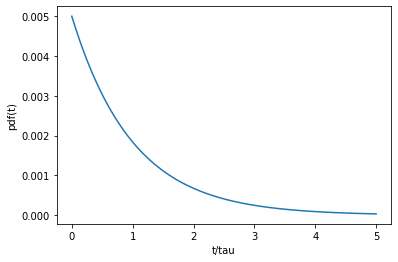

In [43]:
tau=0.8
def pdf(t):
    return np.exp(-t/tau)/tau

X_disc=1000
xmin=0
xmax=5*tau

dx=(xmax-xmin)/X_disc

x=np.linspace(xmin,xmax,X_disc)

plt.plot(x/tau,pdf(x)*dx)
plt.xlabel("t/tau")
plt.ylabel("pdf(t)")
plt.savefig("3_1_a1.png",dpi=600)


Now lets generate the numbers we wanted and plot them.


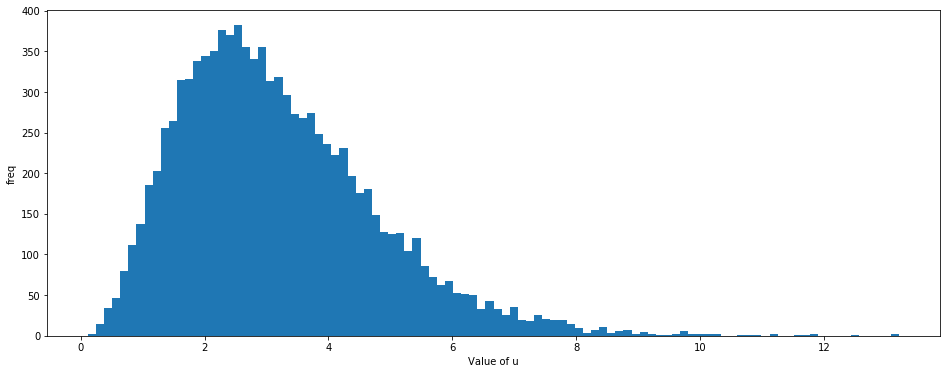

In [44]:
#Numpy has the exponential distribution that we want, so this is easy:

n=4
N=10000

r.seed(1)

Samples=r.exponential(tau,(N,n))
Samples=np.sum(Samples,axis=1)

Nbins=int(np.sqrt(N))

figU, axU = plt.subplots(figsize=(16, 6));

counts,bin_edges,_=axU.hist(Samples,bins=Nbins,label="Generated numbers")
plt.xlabel("Value of u")
plt.ylabel("freq")
plt.savefig("3_1_a2.png",dpi=600)

Even with only 4 numbers added the distrubution looks suspiciously gaussian... The CLT really is powerful. 

##### b)
Now we actually want to fit with a gaussian. Lets use chisquare, its easy and robust:

Chi2 value: 1283.2   Ndof = 84    Prob(Chi2,Ndof) = 9.188578141698317e-214


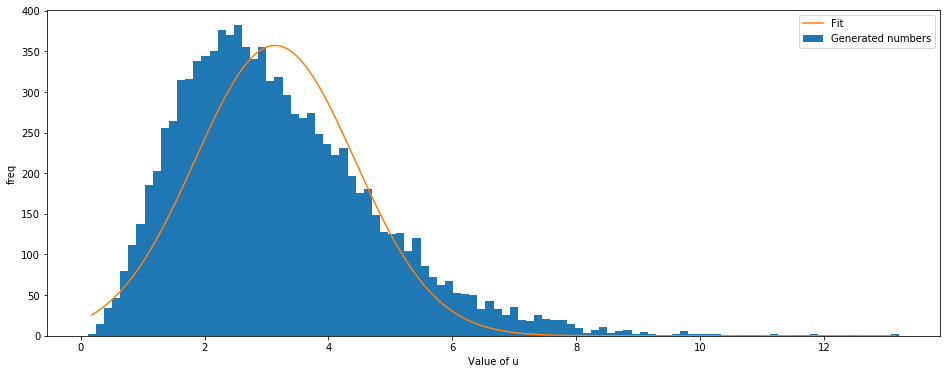

In [45]:
binwidth=bin_edges[1]-bin_edges[0]
def Gaussian_fit_function(x, mu, A, sig): #define a gaussian to fit
    return binwidth*A*np.exp(-0.5*((x-mu)/sig)**2)/(sig*np.sqrt(2*np.pi))

eu=np.sqrt(counts) #square root-rules to get uncertainties

bin_values=(bin_edges[0:-1]+bin_edges[1::])/2

def chi2_Gaussian(mu, A, sig) :
    y_fit = Gaussian_fit_function(bin_values[counts>0], mu, A, sig)
    chi2 = np.sum(((counts[counts>0] - y_fit) / eu[counts>0])**2)
    return chi2

chi2_Gaussian.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_Gaussian,mu=1, A=np.max(counts), sig=1)
minuit.migrad()

sig_fit = minuit.values['sig']
A_fit = minuit.values['A']
mu_fit = minuit.values['mu']

x=np.linspace(bin_values[0],bin_values[-1],1000)

axU.plot(x,Gaussian_fit_function(x, mu_fit, A_fit, sig_fit),label="Fit")
axU.legend()

chi2=minuit.fval
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - minuit.nfit

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

figU.savefig("3_1_b1.png",dpi=600)
figU

We see that the fit is not really that great, the p-value is very small, and in the plot we clearly see that the distribution is asymetrical enough that the shape is not gaussian. This is due to only sampling 4 numbers from f(t). Had we sampled somthing like 1000 I suspect the gaussian would fit the result very well:

Chi2 value: 79.4   Ndof = 92    Prob(Chi2,Ndof) = 0.8217501177175326


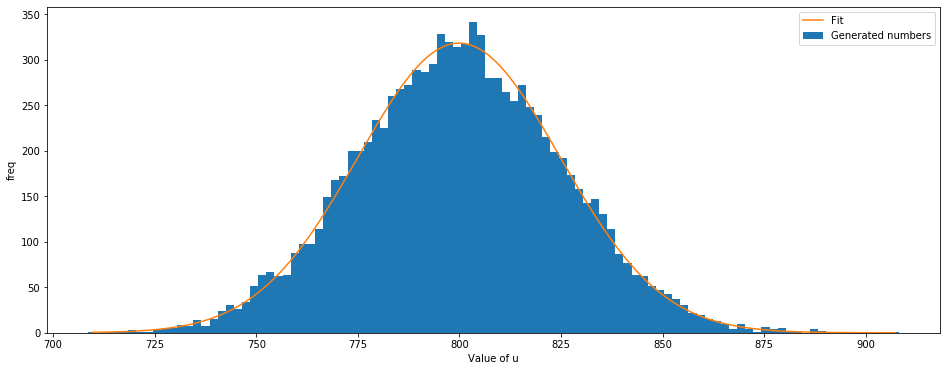

In [46]:
n=1000
N=10000

Samples=r.exponential(tau,(N,n))
Samples=np.sum(Samples,axis=1)

Nbins=int(np.sqrt(N))

figU, axU = plt.subplots(figsize=(16, 6));

counts,bin_edges,_=axU.hist(Samples,bins=Nbins,label="Generated numbers")
plt.xlabel("Value of u")
plt.ylabel("freq")

binwidth=bin_edges[1]-bin_edges[0]
def Gaussian_fit_function(x, mu, A, sig): #define a gaussian to fit
    return binwidth*A*np.exp(-0.5*((x-mu)/sig)**2)/(sig*np.sqrt(2*np.pi))

eu=np.sqrt(counts) #square root-rules to get uncertainties

bin_values=(bin_edges[0:-1]+bin_edges[1::])/2

def chi2_Gaussian(mu, A, sig) :
    y_fit = Gaussian_fit_function(bin_values[counts>0], mu, A, sig)
    chi2 = np.sum(((counts[counts>0] - y_fit) / eu[counts>0])**2)
    return chi2

chi2_Gaussian.errordef = 1.0    # Chi2 definition (for Minuit)

minuit = Minuit(chi2_Gaussian,mu=800, A=np.max(counts), sig=20)
minuit.migrad()

sig_fit = minuit.values['sig']
A_fit = minuit.values['A']
mu_fit = minuit.values['mu']

x=np.linspace(bin_values[0],bin_values[-1],1000)

axU.plot(x,Gaussian_fit_function(x, mu_fit, A_fit, sig_fit),label="Fit")
axU.legend()

chi2=minuit.fval
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - minuit.nfit

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

figU.savefig("3_1_b2.png",dpi=600)


##### c)
We now want to try fitting other shapes. Lets first try with the function i used in 1.3:

Chi2 value: 583.1   Ndof = 83    Prob(Chi2,Ndof) = 3.576459632897776e-76


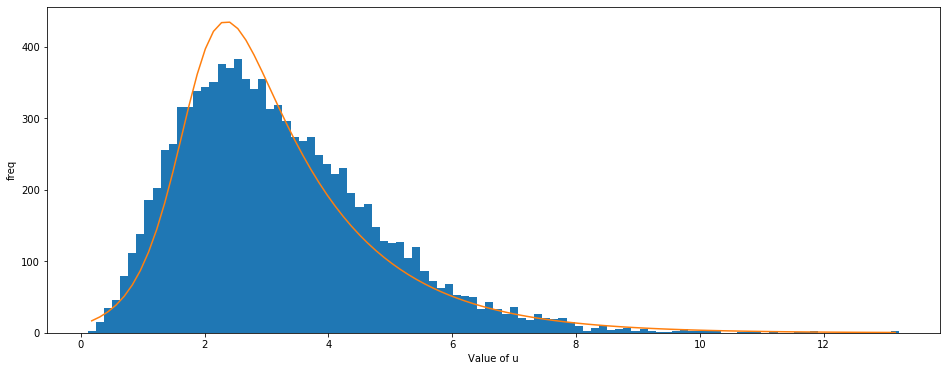

In [47]:
n=4
N=10000

r.seed(1)

Samples=r.exponential(tau,(N,n))
Samples=np.sum(Samples,axis=1)

eSamples=np.sqrt(Samples) #square root-rules to get uncertainties
Nbins=int(np.sqrt(N))

figU, axU = plt.subplots(figsize=(16, 6));
counts,bin_edges,_=axU.hist(Samples,bins=Nbins,label="Generated numbers")
plt.xlabel("Value of u")
plt.ylabel("freq")

e_counts=np.sqrt(counts) #square root-rules to get uncertainties
bin_values=(bin_edges[0:-1]+bin_edges[1::])/2
binwidth=bin_edges[1]-bin_edges[0]

def Double_Exp_fit_function(x, A, alpha, beta,x0): #define a function to fit with
    return binwidth*A/(1+np.exp(-(x-x0)/alpha))*np.exp(-(x-x0)/beta)

def chi2_Exp(A,alpha, beta, x0) :
    y_fit = Double_Exp_fit_function(bin_values[counts>0], A,alpha, beta,x0)
    chi2 = np.sum(((counts[counts>0] - y_fit) / e_counts[counts>0])**2)
    return chi2

chi2_Exp.errordef = 1.0    # Chi2 definition (for Minuit)

A_guess=5000
alpha_guess=0.5
beta_guess=1.3
x0_guess=2.3

minuit = Minuit(chi2_Exp, A=A_guess, alpha=alpha_guess, beta=beta_guess, x0=x0_guess)
minuit.migrad()

alpha_fit = minuit.values['alpha']
beta_fit = minuit.values['beta']
A_fit = minuit.values['A']
x0_fit = minuit.values['x0']

x=np.linspace(bin_values[0],bin_values[-1],Nbins)

#axU.plot(x,Double_Exp_fit_function(x, A_guess, alpha_guess,beta_guess,x0_guess),label='Guess')
axU.plot(x,Double_Exp_fit_function(x, A_fit, alpha_fit,beta_fit,x0_fit),label='1.3 function')

chi2=minuit.fval
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - minuit.nfit

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")


Its not a truly great fit, but at least it captures the asymmetry of the distribution. Perhaps use a*x*exp(-x*b)

Chi2 value: 585.8   Ndof = 84    Prob(Chi2,Ndof) = 2.958372627716328e-76
Chi2 value: 81.4   Ndof = 83    Prob(Chi2,Ndof) = 0.53023720053531


C:\Users\rober\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in power
C:\Users\rober\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in greater


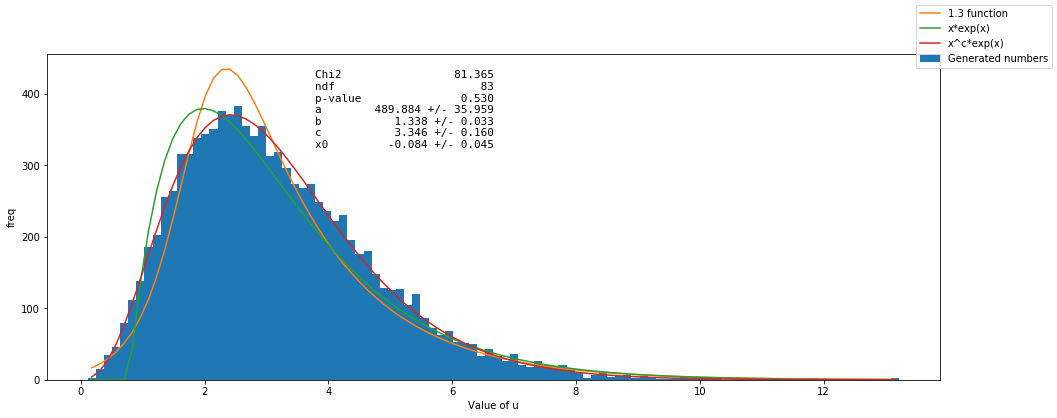

In [48]:
def f(x,a,b,x0):
    s=a*(x-x0)*np.exp(-(x-x0)*b)
    s=np.where(s>0,s,0)
    return s

def chi2_f(a,b,x0) :
    y_fit = f(bin_values[counts>0], a,b,x0)
    chi2 = np.sum(((counts[counts>0] - y_fit) / e_counts[counts>0])**2)
    return chi2

chi2_f.errordef = 1.0    # Chi2 definition (for Minuit)

a_guess=1000
b_guess=1.3
x0_guess=0.1

minuit = Minuit(chi2_f, a=a_guess, b=b_guess, x0=x0_guess)
minuit.migrad()

a_fit = minuit.values['a']
b_fit = minuit.values['b']
x0_fit = minuit.values['x0']

x=np.linspace(bin_values[0],bin_values[-1],Nbins)

#axU.plot(x,f(x, a_guess,b_guess,x0_guess),label='Guess')
axU.plot(x,f(x, a_fit,b_fit,x0_fit),label='x*exp(x)')

chi2=minuit.fval
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - minuit.nfit

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")


def f2(x,a,b,c,x0):
    s=a*(x-x0)**c*np.exp(-(x-x0)*b)
    s=np.where(s>0,s,0)
    return s

def chi2_f2(a,b,c,x0) :
    y_fit = f2(bin_values[counts>0], a,b,c,x0)
    chi2 = np.sum(((counts[counts>0] - y_fit) / e_counts[counts>0])**2)
    return chi2

chi2_f2.errordef = 1.0    # Chi2 definition (for Minuit)

a_guess=1000
b_guess=1.3
c_guess=1.
x0_guess=0.1

minuit = Minuit(chi2_f2, a=a_guess, b=b_guess,c=c_guess, x0=x0_guess)
minuit.migrad()

a_fit = minuit.values['a']
b_fit = minuit.values['b']
c_fit = minuit.values['c']
x0_fit = minuit.values['x0']

x=np.linspace(bin_values[0],bin_values[-1],Nbins)

#axU.plot(x,f(x, a_guess,b_guess,x0_guess),label='Guess')
axU.plot(x,f2(x, a_fit,b_fit,c_fit,x0_fit),label='x^c*exp(x)')

chi2=minuit.fval
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - minuit.nfit

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

d = {'Chi2':     chi2,
     'ndf':      Ndof_value,
     'p-value':  stats.chi2.sf(chi2, Ndof_value)
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.3, 0.95, text, axU, fontsize=11)


figU.legend()
figU.savefig("3_1_c1.png",dpi=600)
figU

#### 3.2
We have the pdf $C \cdot x \cdot  \exp(-x)$ Lets first determine C, by requiring: $1=\int_{0}^{\inf} C \cdot x \cdot  \exp(-x) dx$

Solving the integral we arrive at $C=1$ (Can do this with sympy)

We can do this exercise in many different ways. First we can just do a quick and easy accept/reject with a big bix, truncating the pdf at some high value (like a thousand lifetimes), then we can try using the transformational method, or even a combination of the two, to get a 'smart' box.

Lets sample the values with the accept-reject method, setting x_max at 1000


Integral under pdf in region: 0.99998
Efficiency of method: 0.00269
median is 1.5900817809075818
max of pdf is at 1.0000230787529079
Chi2 value: 17.9   Ndof = 23    Prob(Chi2,Ndof) = 0.7609263920668913


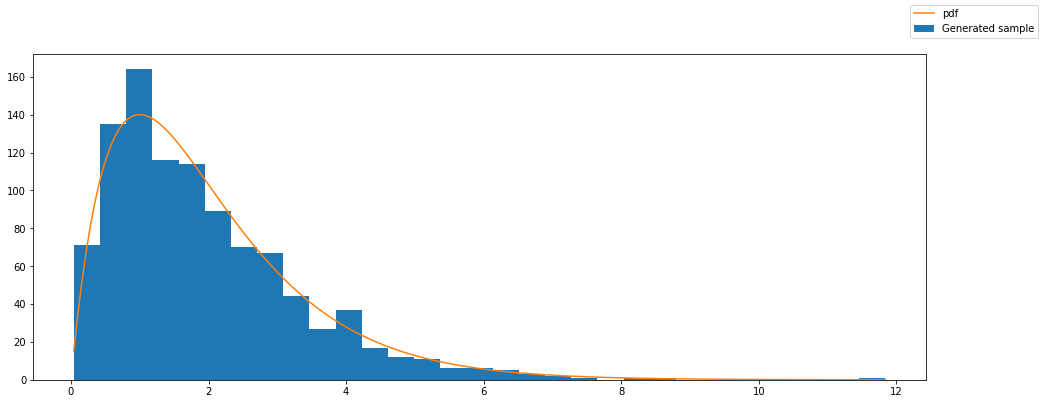

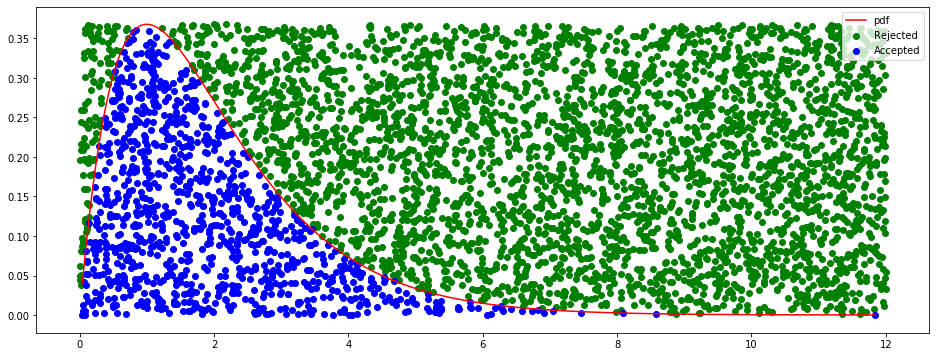

In [49]:
def f(x):
    return x*np.exp(-x)

N=1000
xmax=1000
xmin=0

X_disc=100000
dx=(xmax-xmin)/X_disc
x=np.linspace(xmin,xmax,X_disc)

print(f"Integral under pdf in region: {np.sum(f(x)*dx):.5f}")
fmax=np.max(f(x))

samples=np.zeros(N)
accepted=0
points_total=0
r.seed(1)

x1_list_A = []
x2_list_A = []

x1_list_R = []
x2_list_R = []

plotCutoff=12

while accepted<N: #Try to get N accepted values
    points_total+=1
    x1=r.random()*xmax
    x2=r.random()*fmax
    if (x2<f(x1)): #accept criterion
        samples[accepted]=x1
        accepted+=1
        if x1<plotCutoff:
            x1_list_A.append(x1)
            x2_list_A.append(x2)
    else:
        if x1<plotCutoff:
            x1_list_R.append(x1)
            x2_list_R.append(x2)
print(f"Efficiency of method: {accepted/points_total:.5f}")

figC, axC = plt.subplots(figsize=(16, 6));
Nbins=int(np.sqrt(N))
counts,bin_edges,_=axC.hist(samples,bins=Nbins,label="Generated sample")
binwidth=bin_edges[1]-bin_edges[0]
bin_values=(bin_edges[1::]+bin_edges[0:-1])/2
x_axis=x=np.linspace(bin_edges[0],bin_edges[-1],X_disc)
axC.plot(x_axis,binwidth*N*f(x_axis),label="pdf")
figC.legend()



#Now determine median:
print(f"median is {np.median(samples)}")
print(f"max of pdf is at {x[np.argmax(f(x))]}")
chi2=np.sum(((f(bin_values[counts>0])*binwidth*N-counts[counts>0])/np.sqrt(counts[counts>0]))**2)
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - 0

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

figAR, axAR = plt.subplots(figsize=(16, 6));
axAR.plot(x_axis,f(x_axis),color='r',label="pdf")
axAR.scatter(x1_list_R,x2_list_R,color='g',label="Rejected")
axAR.scatter(x1_list_A,x2_list_A,color='b',label="Accepted")
plt.legend()
figC.savefig("3_2_a1.png",dpi=600)
figAR.savefig("3_2_a2.png",dpi=600)

The samples seem to follow the pdf reasonably well, and the computed p-value is reasonable. We also see that the truncation was not that critical, as we have an integral under the truncated pdf of almost unity.

We could stop now, and be satisfied. lets instead try solving it in a better way, as we observed an efficiency around 0.3%:

We want to use the transformational method now.
We already normalized the pdf, so now we obtain the cdf by integrating:

$F(x)=\int_{0}^x dx' f(x') = \int_{0}^x dx' x'\cdot \exp(-x')$

Let use sympy, since I dont want to do partial integration:


(-y - 1)*exp(-y) + 1

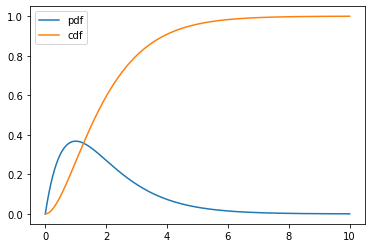

In [50]:
x=Symbol("x")
y=Symbol("y")
F=Symbol("F")
eq=integrate(x*exp(-x),(x,0,y))

xmax=10
xmin=0
X_disc=1000
dx=(xmax-xmin)/X_disc
x_axis=np.linspace(xmin,xmax,X_disc)

_=plt.plot(x_axis,f(x_axis),label="pdf")
_=plt.plot(x_axis,lambdify(y,eq)(x_axis),label="cdf")
plt.legend()
plt.savefig("3_2_a3.png",dpi=600)
eq

Now we just need to invert this equation:

In [51]:
solution=solve(eq-F,y)[0]
solution

-LambertW((F - 1)*exp(-1)) - 1

This is not a nice expression, but scipy has the LambertW function, so we can still proceed in principle.
The implementaton in scipy is has some issues close to 0 and 1, but other than that we see it works:

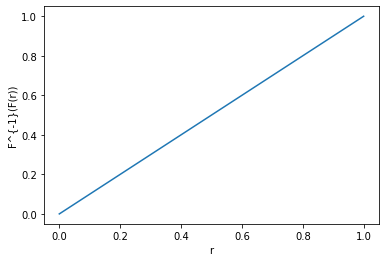

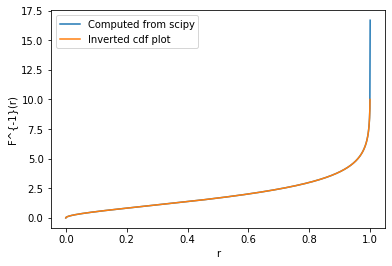

In [52]:
def func(F):
    return -1-sci.special.lambertw((F-1)/np.e,k=-1)

rmin=0.000001
rmax=0.999999
R=np.linspace(rmin,rmax,1000)


plt.plot(R,lambdify(y,eq)(np.real(func(R))))
plt.xlabel("r")
plt.ylabel("F^{-1}(F(r))")
plt.savefig("3_2_a4.png",dpi=600)

plt.figure()

plt.plot(R,np.real(func(R)),label="Computed from scipy")
plt.plot(lambdify(y,eq)(x_axis),x_axis,label="Inverted cdf plot")
plt.legend()
plt.xlabel("r")
plt.ylabel("F^{-1}(r)")
plt.savefig("3_2_a5.png",dpi=600)


Lets draw the sample and compute chisquare as before:

median is 1.6500676547083148
max of pdf is at 1.001812198940879
Chi2 value: 20.3   Ndof = 28    Prob(Chi2,Ndof) = 0.8517244752315241


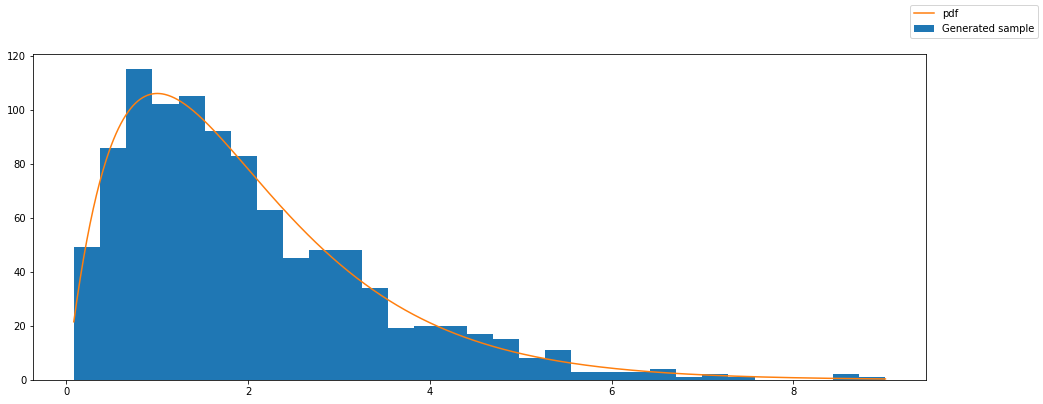

In [53]:
u=r.random(N)
samples=np.real(func(u))

figC, axC = plt.subplots(figsize=(16, 6));
Nbins=int(np.sqrt(N))
counts,bin_edges,_=axC.hist(samples,bins=Nbins,label="Generated sample")
binwidth=bin_edges[1]-bin_edges[0]
bin_values=(bin_edges[1::]+bin_edges[0:-1])/2
x_axis=x=np.linspace(bin_edges[0],bin_edges[-1],X_disc)
axC.plot(x_axis,binwidth*N*f(x_axis),label="pdf")
figC.legend()

#Now determine median:
print(f"median is {np.median(samples)}")
print(f"max of pdf is at {x[np.argmax(f(x))]}")
chi2=np.sum(((f(bin_values[counts>0])*binwidth*N-counts[counts>0])/np.sqrt(counts[counts>0]))**2)
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - 0

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")


figC.savefig("3_2_a6.png",dpi=600)

We see the obtained distribution is also reasonable with this method. The runtime is also much faster with the transformational method, so nicer all around. 

Now we want to consider doing the combination of the two methods, as using the LambertW functon in scipy feels like cheating. 
Since we are doing accept/reject in the end agan, we have to truncate at some value, lets pick 1000 again. 

We have to think of a curve g(x) we can invert anaytically, and which is always larger than f(x).
Since exp(-x) kills everything faster than any other function, we only really have to consider what happens close to x=0, and of course we also want g(x) to go to 0 as x goes to infinity for good efficiency.

Lets use $\frac{1}{x+a}$ where a is positive, so we dont have any singularities in our domain.

1/x goes to 0 slower than exp(-x), so we only have to consider picking a such that $\frac{1}{x+a} > f(x)$ for all positive x.


After plotting and trying a few values, I have arrived at a=1.4 as a good choice:

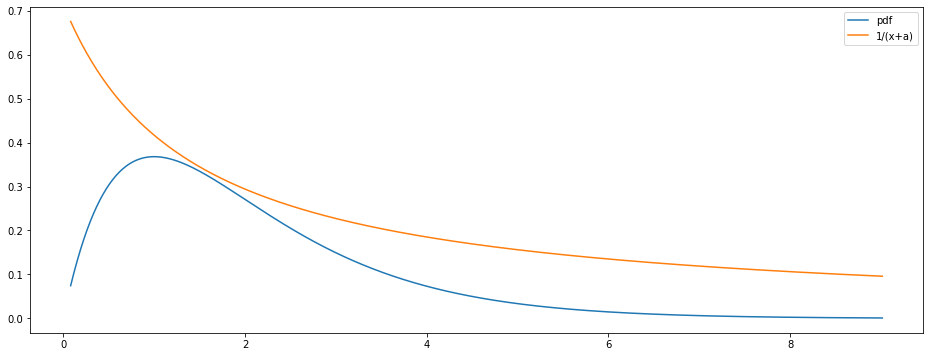

In [54]:
figMC, axMC = plt.subplots(figsize=(16, 6));

def g(x,a):
    return 1/(a+x)

A=1.4

axMC.plot(x_axis,f(x_axis),label="pdf")
axMC.plot(x_axis,g(x_axis,A),label="1/(x+a)")

plt.legend()
plt.savefig("3_2_a7.png",dpi=600)

Now we do the transformational method for the box:

In [55]:
#normalize:
X=Symbol("X_{max}")
x=Symbol("x")
y=Symbol("y")
a=Symbol("a")
F=Symbol("F")
norm=integrate(1/(a+x),(x,0,X))
norm


-log(a) + log(X_{max} + a)

In [56]:
#Generate cdf:
eq=integrate(1/norm*1/(a+x),(x,0,y))

solution=solve(eq-F,y)[0]

solution

a*(-1 + exp(-F*(log(a) - log(X_{max} + a))))

We can now do accept/reject with our brand new shiny box:

Efficiency of method: 0.14966
median is 1.6737493372835348
max of pdf is at 0.9975945591282778
Chi2 value: 15.8   Ndof = 23    Prob(Chi2,Ndof) = 0.8652577870310185


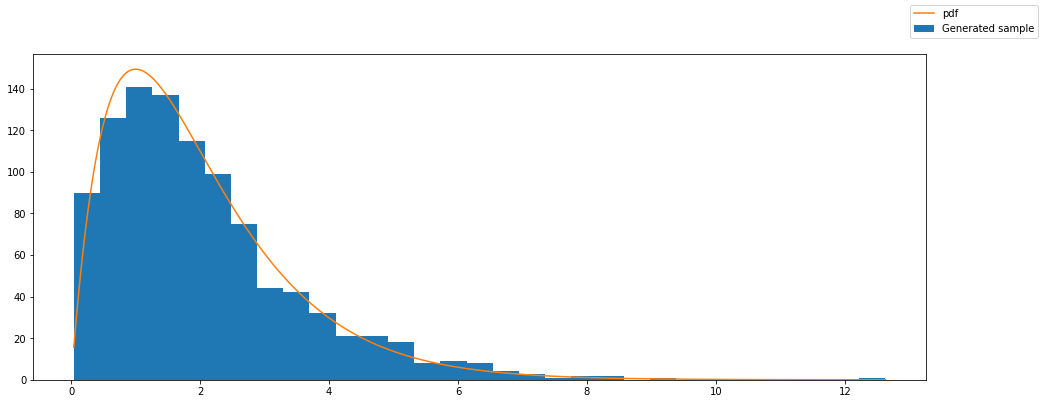

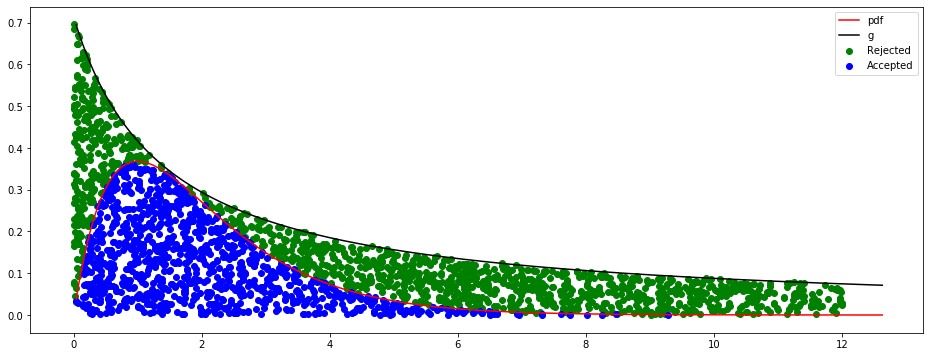

In [57]:
xmax=1000
def smartBox(f):
    return A*(np.exp(-f*(np.log(A)-np.log(xmax+A)))-1)
    #return lambdify((F,a,X),solution)(f,A,xmax)

samples=np.zeros(N)
accepted=0
points_total=0
r.seed(1)

xmax=1000

x1_list_A = []
x2_list_A = []

x1_list_R = []
x2_list_R = []

plotCutoff=12

while accepted<N: #Try to get N accepted values
    points_total+=1
    x1=smartBox(r.random()) #random value in box
    x2=r.random()*g(x1,A)
    if (x2<f(x1)): #accept criterion
        samples[accepted]=x1
        accepted+=1
        if x1<plotCutoff:
            x1_list_A.append(x1)
            x2_list_A.append(x2)
    else:
        if x1<plotCutoff:
            x1_list_R.append(x1)
            x2_list_R.append(x2)
            
print(f"Efficiency of method: {accepted/points_total:.5f}")

figC, axC = plt.subplots(figsize=(16, 6));
Nbins=int(np.sqrt(N))
counts,bin_edges,_=axC.hist(samples,bins=Nbins,label="Generated sample")
binwidth=bin_edges[1]-bin_edges[0]
bin_values=(bin_edges[1::]+bin_edges[0:-1])/2
x_axis=x=np.linspace(bin_edges[0],bin_edges[-1],X_disc)
axC.plot(x_axis,binwidth*N*f(x_axis),label="pdf")
figC.legend()

#Now determine median:
print(f"median is {np.median(samples)}")
print(f"max of pdf is at {x[np.argmax(f(x))]}")
chi2=np.sum(((f(bin_values[counts>0])*binwidth*N-counts[counts>0])/np.sqrt(counts[counts>0]))**2)
N_NotEmptyBin = np.sum(np.where(counts > 0,1,0))
Ndof_value = N_NotEmptyBin - 0

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

figAR, axAR = plt.subplots(figsize=(16, 6));
axAR.plot(x_axis,f(x_axis),color='r',label="pdf")
axAR.plot(x_axis,g(x_axis,A),color='k',label="g")
axAR.scatter(x1_list_R,x2_list_R,color='g',label="Rejected")
axAR.scatter(x1_list_A,x2_list_A,color='b',label="Accepted")
plt.legend()

figC.savefig("3_2_a8.png",dpi=600)
figAR.savefig("3_2_a9.png",dpi=600)

We see that this method also gives us a nice distribution, and that the efficiency is much higher now. 

As a quick note on the median, we could obtain our expectation of this by considering the point where the cdf if equal to 0.5, as we expect half the points to be avove this, and half below:

In [58]:
Expected_median=np.real(func(0.5))
print(f"We expected a median of: {Expected_median:.5f}")


We expected a median of: 1.67835


Which is again in excellent agreement with all of the observed medians. 

### Problem 4

#### 4.1
##### a)

In this exercise we consider the effectiveness of a vaccine. We are given the number of people in a study given the vaccine, and the number given the placebo. We are also given the number of cases of the disease in each group. We first pose the question, what is the probability that the vaccine has no effect?

To answer this we will do a statistical test. We want to test if the two samples could be from the same dsitrubution (in this case the pacebo is the same as the vaccine and we had no effect). 

The number of infected people is a small number(chance of getting infected) multiplied by a large number(many people in experiment), so we can expect that it will follow poissonian statistics, and thus the errors are given by the square root. If we further assume that the outcome of the experiment will follow a gaussian. (I.e. put our faith in the CLT, and that the experiment depends on many factorsm of which none dominate the others) we can do a simple test:

We will first compute the rates and errors on the rates. Then we will compute the difference of the rates, and check how many sigma this is from 0. We will then check the area under the gaussian distribution with this distance or greater from the mean. (A two-tailed z test)


In [59]:
#define numbers given:
Np=21728
Np_I=162
Nv=21720
Nv_I=8
#compute errors:
eNv_I=np.sqrt(Nv_I)
eNp_I=np.sqrt(Np_I)

#compute rate:
Rp=Np_I/Np
Rv=Nv_I/Nv
#compute error on rate (simple error-propagation):
eRp=eNp_I/Np
eRv=eNv_I/Nv

#Find difference of rates:
R_diff=np.abs(Rp-Rv)
#Find error of difference:
stdR_diff=np.sqrt(eRv**2+eRp**2)

#How many std are we from 0?:
dist_std=R_diff/stdR_diff

print(f"The ditance to 0 is {dist_std:.3f} in units of the std")

p=2*stats.norm.cdf(-dist_std,loc=0,scale=1)
print(f"The p-value for the samples to be from the same distribution is {p}")

The ditance to 0 is 11.811 in units of the std
The p-value for the samples to be from the same distribution is 3.431565443890656e-32


So this quick and simple test tells us it is very unlikely that the vaccine had no effect. 

##### b)
We now look at the efficacy defined as:

$\epsilon = \frac{N_{placebo}-N_{vaccine}}{N_{placebo}}$

We want to find the 68% confidence interval, i.e. the one sigma interval (Assuming it is gaussianly distributed).


In [60]:
#compute epsilon:
epsilon=(Np_I-Nv_I)/Np_I

#Error on epsilon:
eepsilon=np.sqrt((eNv_I/Np_I)**2+(eNp_I*Nv_I/Np_I**2)**2) #simple error-prop

print(f"The one sigma confidence interval for the efficacy is: {(epsilon-eepsilon):.4f} to {(epsilon+eepsilon):.4f}")


The one sigma confidence interval for the efficacy is: 0.9327 to 0.9685


We could now proceed to do this numerically, drawing different numbers of infected from two poisson distributions (N times), computing the efficacy for each pair of generated numbers, plotting and doing a numerical integration to obtain the confidence interval.

0.9355
0.9535
0.9715


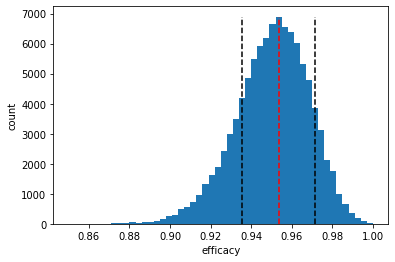

In [61]:

N=100000
epsilons=np.zeros(N)

for n in range (N):
    
    Np_I_n=r.poisson(Np_I)
    Nv_I_n=r.poisson(Nv_I)
    
    epsilons[n]=(Np_I_n-Nv_I_n)/Np_I_n
    

xmin=0.85
xmax=1.
Nbins=50

counts,bin_edges,_=plt.hist(epsilons,bins=Nbins,range=(xmin,xmax))
plt.xlabel("efficacy")
plt.ylabel("count")

bin_values=(bin_edges[0:-1]+bin_edges[1::])/2

p=0.68

cdf=np.array([np.sum(counts[0:i])/N for i in range(len(counts))])

center=np.min(bin_values[cdf>0.5])
top=np.min(bin_values[cdf>0.5+p/2])
bottom=np.min(bin_values[cdf>0.5-p/2])

print(bottom)
print(center)
print(top)


plt.plot([center,center],[0,np.max(counts)],color='r',linestyle='--')
plt.plot([top,top],[0,np.max(counts)],color='k',linestyle='--')
plt.plot([bottom,bottom],[0,np.max(counts)],color='k',linestyle='--')

plt.savefig("4_1_b1.png",dpi=600)

##### c)
We now look at a much reduced dataset, knowing only that there were 10 severe cases and that nine of them  were in the placebo-group. Unless we also know the sizes of the two groups, we cannot use this information for anything, as it could simply be that one group was much larger than the other. If we make the assumption that the groups have equal size, we can do an analysis just like the one in part 4.1a. However we run into the issue that we have very low statistics, so that our estimate of the error from the sqrt might not be accurate. 


In [62]:
Sp=9
Sv=1

eSp=np.sqrt(Sp)
eSv=np.sqrt(Sv)

diff=np.abs(Sp-Sv)
std=np.sqrt(eSp**2+eSv**2)

#How many std are we from 0?:
dist_std=diff/std

print(f"The ditance to 0 is {dist_std:.3f} in units of the std")

p=2*stats.norm.cdf(-dist_std,loc=0,scale=1)
print(f"The p-value for the samples to be from the same distribution is {p:.4f}")


The ditance to 0 is 2.530 in units of the std
The p-value for the samples to be from the same distribution is 0.0114


We see that even with this much reduced dataset, the probability that the data is consistent with there being no effect is only around 1%. Not enough to kill the null-hypothesis in many fields, but still above 2 sigma. 


#### 4.2
##### a)
We now consider drawing 4 cards from a shuffled deck of 52 cards. ($13 \cdot 4$) If we replace the drawn cards by putting them back in the deck after inspecting them, we want to know the distribution the number of aces drawn will follow. 

Since the number of trials is well defined (4) and the proabilityt of a sucess (4/52) is the same, the number will be binomally distributed.

We now want to compute the chance of getting 3 or more aces. 


Probability of drawing 3 or more aces: 0.00172


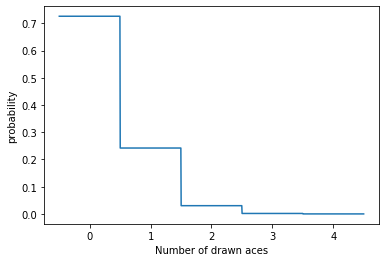

In [63]:
x=np.linspace(-0.5,4.5,1000)
pdf=stats.binom.pmf(np.floor(x+0.5),4,4/52)

plt.plot(x,pdf)
plt.xlabel("Number of drawn aces")
plt.ylabel("probability")

p=1-stats.binom.cdf(2,4,4/52)
print(f"Probability of drawing 3 or more aces: {p:.5f}")

plt.savefig("4_2_a1.png",dpi=600)

##### b)
We now consider the problem without replacement. I am sure this can be done analytically, but I will not bother with it and instead go straight for a simulation.

We will assume a perfectly shuffled deck.


Observed probability for 3 or more aces: 0.00078


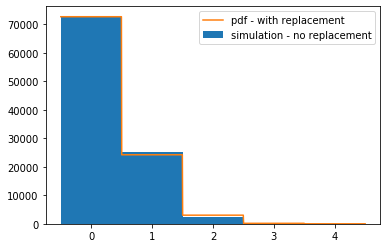

In [64]:
N=100000
M=4 #cards to draw n total
A=4 #cards we consider a sucess (4 aces)
Z=52 #total size of deck

Result=np.zeros(N)

r.seed(1) #reproducability

for i in range(N):
    n=0 #how many we got thus far
    for j in range(M):
        c=r.random()
        if c<((A-n)/(Z-n)):
            n+=1 # we had a succes
        else:
            n=n #do nothing
    Result[i]=n

counts,binedges,_=plt.hist(Result,bins=5,range=(-0.5,4.5),label="simulation - no replacement")

x=np.linspace(-0.5,M+0.5,1000)
pdf=stats.binom.pmf(np.floor(x+0.5),M,A/Z)

plt.plot(x,pdf*N,label="pdf - with replacement")
plt.legend()

print(f"Observed probability for 3 or more aces: {np.sum(counts[3:])/np.sum(counts)}")
plt.savefig("4_2_b1.png",dpi=600)

As you might intuitively expect, the probability for 3 or more aces is now lower. This is due to the decreasing chance of drawing an ace when you have already drawn one or more. We also see that the proability of not drawing any aces is the same as before, which is expected, since the replacement has no effect here. We see that the probability of drawing 1 ace has increased slightly, this is due to all the times where we before would have redrawn the same ace, we now only draw it once.

##### c)
We now consider a deck supplied to us:

In [65]:
data = np.genfromtxt("./data_ShuffledCards.txt", skip_header=2)
number = data[:,0]
value = data[:,4]
suit = data[:,5]

Troels_deck=np.array([value,suit]).T #put in my format

And want to determine if these are well shuffled.

I will approach this by considering simulations of perfectly shuffled decks (trusting numpy to be compltely random, not really true, but close enough). We will then find some good test-statistic to tell shuffled cards from ordered cards.


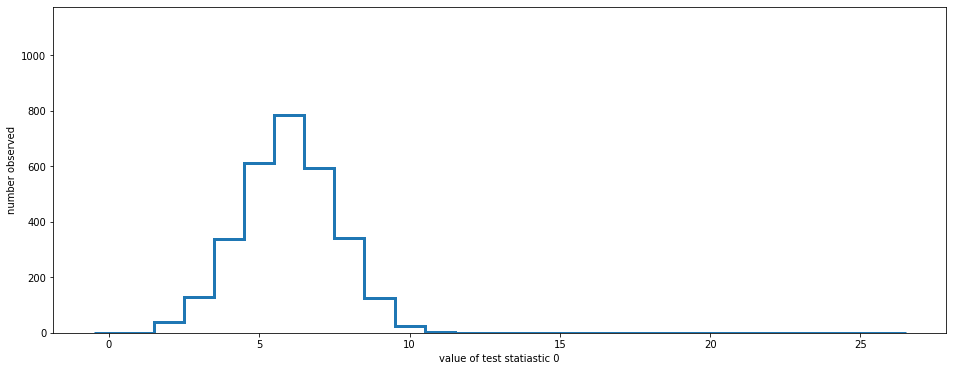

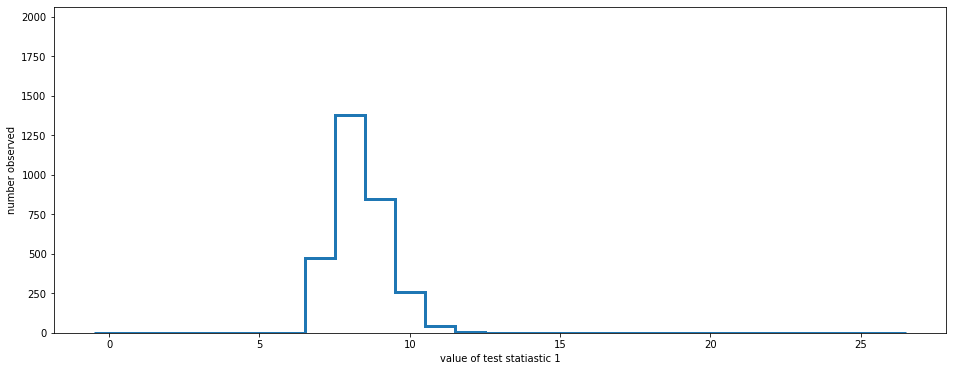

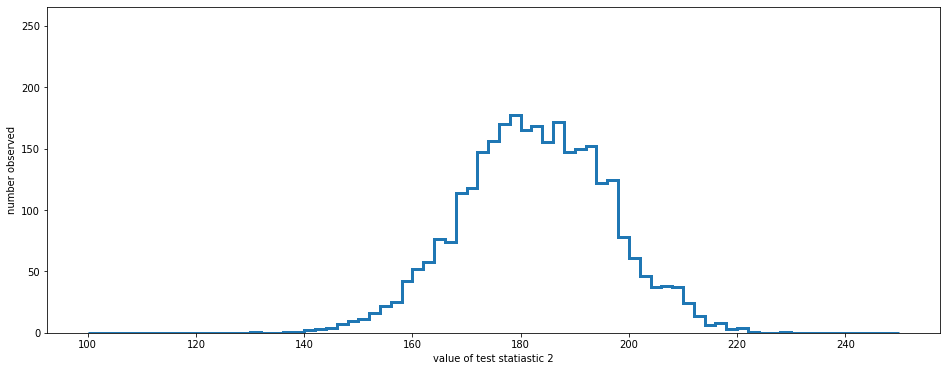

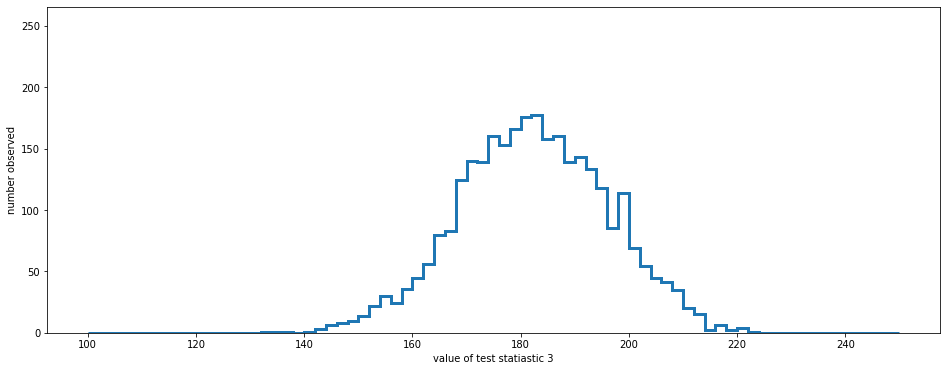

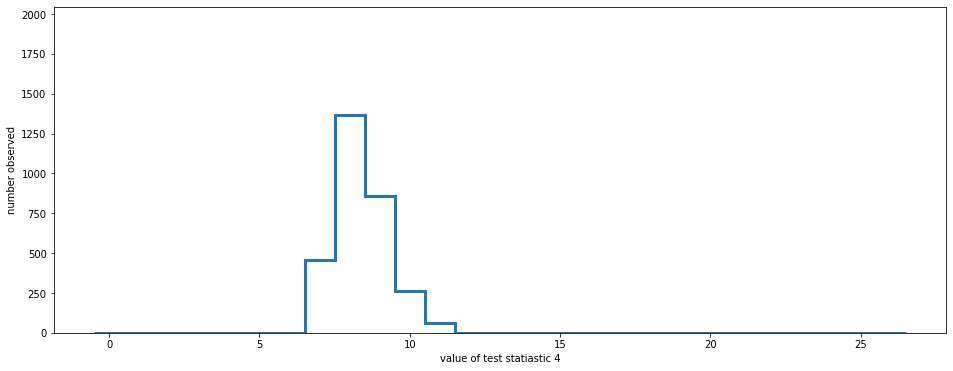

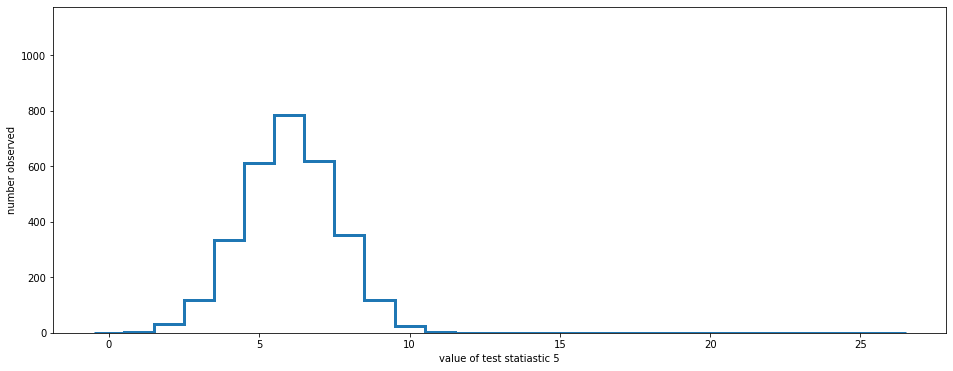

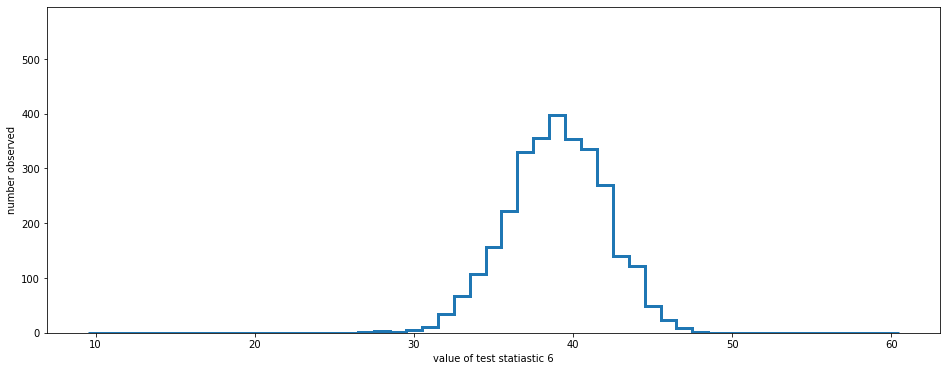

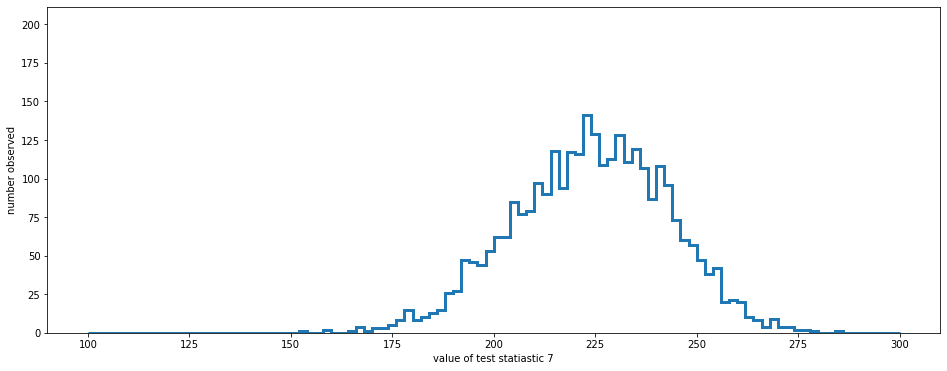

In [66]:
#We first generate some shuffled decks:
r.seed(1) #reproducability

Deck=np.ones((52,2)) #value,suit
#Define suits:
Deck[13:26,1]=2
Deck[26:39,1]=3
Deck[39:52,1]=4
#Define values:
Deck[0:13,0]=np.arange(13)+1
Deck[13:26,0]=np.arange(13)+1
Deck[26:39,0]=np.arange(13)+1
Deck[39:52,0]=np.arange(13)+1

def statistic_0(deck,n,m): 
    #look at first n cards and see how many are above m in value
    sample=deck[0:n,0]
    return np.sum(sample>m)

def statistic_1(deck,n): 
    #look at first n cards and see how many have same suit
    sample=deck[0:n,1]
    return np.max([np.sum(sample==1),np.sum(sample==2),np.sum(sample==3),np.sum(sample==4)])

def statistic_2(deck): 
    #look at even cards and determine their sum
    sample=deck[::2,0]
    return np.sum(sample)

def statistic_3(deck,n): 
    #look at top n cards and determine their sum
    sample=deck[0:n,0]
    return np.sum(sample)

def statistic_4(deck): 
    #look at even cards and determine how many have same suit
    sample=deck[::2,1]
    return np.max([np.sum(sample==1),np.sum(sample==2),np.sum(sample==3),np.sum(sample==4)])

def statistic_5(deck,m): 
    #look at even cards and determine how many are above m
    sample=deck[::2,0]
    return np.sum(sample>m)

def statistic_6(deck): 
    #look at all cards, and copute how many times we change suit (a 'run' test)
    r=0
    for i,card in enumerate(deck):
        if i>0:
            if card[1]!=deck[i-1,1]:
                r+=1
    return r

def statistic_7(deck): 
    #look at all cards, and return sum of (absolute) difference from last card
    r=0
    for i,card in enumerate(deck):
        if i>0:
            r+=np.abs(card[0]-deck[i-1,0])
    return r


N=3000 #number of simulations
M=8 #number of statistics
L=3 #Number of orderings

results=np.zeros((N,M))

n=26 #look at half deck
m=10 #look for picture-cards

for i in range(N):
    Shuffled=Deck.copy() # copy base deck
    r.shuffle(Shuffled) # shuffle the deck
    results[i,0]=statistic_0(Shuffled,n,m)
    results[i,1]=statistic_1(Shuffled,n)
    results[i,2]=statistic_2(Shuffled)
    results[i,3]=statistic_3(Shuffled,n)
    results[i,4]=statistic_4(Shuffled)
    results[i,5]=statistic_5(Shuffled,m)
    results[i,6]=statistic_6(Shuffled)
    results[i,7]=statistic_7(Shuffled)

top=1.5
    
figC0, axC0 = plt.subplots(figsize=(16, 6));
countsSC0,bin_edgesSC0,_=axC0.hist(results[:,0],bins=n+1,range=(-0.5,n+0.5),label="Shuffled Deck",histtype="step",linewidth=3)
plt.ylim(0,np.max(countsSC0)*top)
plt.ylabel("number observed")
plt.xlabel("value of test statiastic 0")

figC1, axC1 = plt.subplots(figsize=(16, 6));
countsSC1,bin_edgesSC1,_=axC1.hist(results[:,1],bins=n+1,range=(-0.5,n+0.5),label="Shuffled Deck",histtype="step",linewidth=3)
plt.ylim(0,np.max(countsSC1)*top)
plt.ylabel("number observed")
plt.xlabel("value of test statiastic 1")

figC2, axC2 = plt.subplots(figsize=(16, 6));
countsSC2,bin_edgesSC2,_=axC2.hist(results[:,2],bins=75,range=(100,250),label="Shuffled Deck",histtype="step",linewidth=3)
plt.ylim(0,np.max(countsSC2)*top)
plt.ylabel("number observed")
plt.xlabel("value of test statiastic 2")

figC3, axC3 = plt.subplots(figsize=(16, 6));
countsSC3,bin_edgesSC3,_=axC3.hist(results[:,3],bins=75,range=(100,250),label="Shuffled Deck",histtype="step",linewidth=3)
plt.ylim(0,np.max(countsSC3)*top)
plt.ylabel("number observed")
plt.xlabel("value of test statiastic 3")

figC4, axC4 = plt.subplots(figsize=(16, 6));
countsSC4,bin_edgesSC4,_=axC4.hist(results[:,4],bins=n+1,range=(-0.5,n+0.5),label="Shuffled Deck",histtype="step",linewidth=3)
plt.ylim(0,np.max(countsSC4)*top)
plt.ylabel("number observed")
plt.xlabel("value of test statiastic 4")

figC5, axC5 = plt.subplots(figsize=(16, 6));
countsSC5,bin_edgesSC5,_=axC5.hist(results[:,5],bins=n+1,range=(-0.5,n+0.5),label="Shuffled Deck",histtype="step",linewidth=3)
plt.ylim(0,np.max(countsSC5)*top)
plt.ylabel("number observed")
plt.xlabel("value of test statiastic 5")

figC6, axC6 = plt.subplots(figsize=(16, 6));
countsSC6,bin_edgesSC6,_=axC6.hist(results[:,6],bins=51,range=(10-0.5,60+0.5),label="Shuffled Deck",histtype="step",linewidth=3)
plt.ylim(0,np.max(countsSC6)*top)
plt.ylabel("number observed")
plt.xlabel("value of test statiastic 6")

figC7, axC7 = plt.subplots(figsize=(16, 6));
countsSC7,bin_edgesSC7,_=axC7.hist(results[:,7],bins=100,range=(100,300),label="Shuffled Deck",histtype="step",linewidth=3)
plt.ylim(0,np.max(countsSC7)*top)
plt.ylabel("number observed")
plt.xlabel("value of test statiastic 7")

S_counts_LIST=[countsSC0,countsSC1,countsSC2,countsSC3,countsSC4,countsSC5,countsSC6,countsSC7]
S_binEdges_LIST=[bin_edgesSC0,bin_edgesSC1,bin_edgesSC2,bin_edgesSC3,bin_edgesSC4,bin_edgesSC5,bin_edgesSC6,bin_edgesSC7]

Now that we have some distributions for shuffled cards, lets make some ordered decks and see how their distributions are.

We will make two sanity-check decks, that are completely ordered in either suits or values, to check that the test-statistics give the expected values for these scenarios. We will then make a more deviously sorted deck, such that cards following each other are simmilar in some way, i.e. close in value or same suit. When playing a cardgame decks like these could look random, but still favor some players. For instance one player is likely to end up with many high cards, if they are clustered togehter. (Assuming we give cards to players such that one get the first N cards of the deck, the next the next N cards and so on. In reality a final 'shuffling' often takes place as cards are given in pairs or in ones. However in our simulated world, we can simply absorb this into the initial shuffling.)

So in the end we want to find out which stistic to use for telling if Troel's deck belongs to the 'random' distribution, or the 'simmilar' distribution.


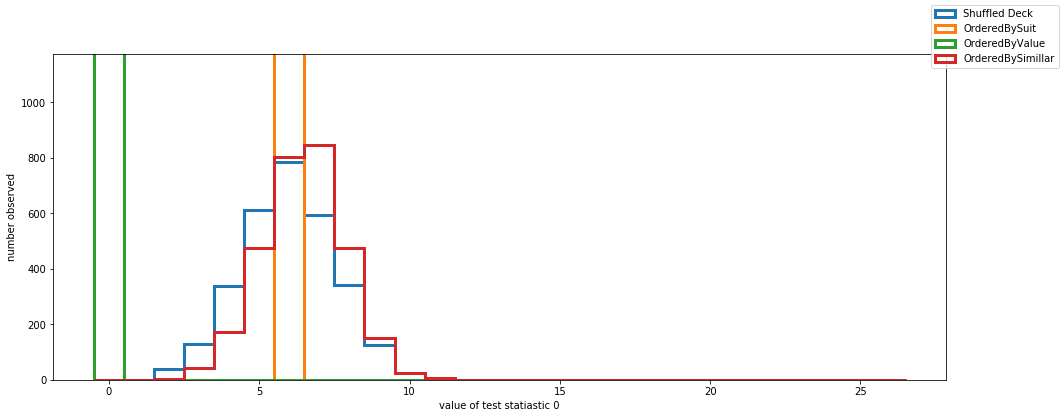

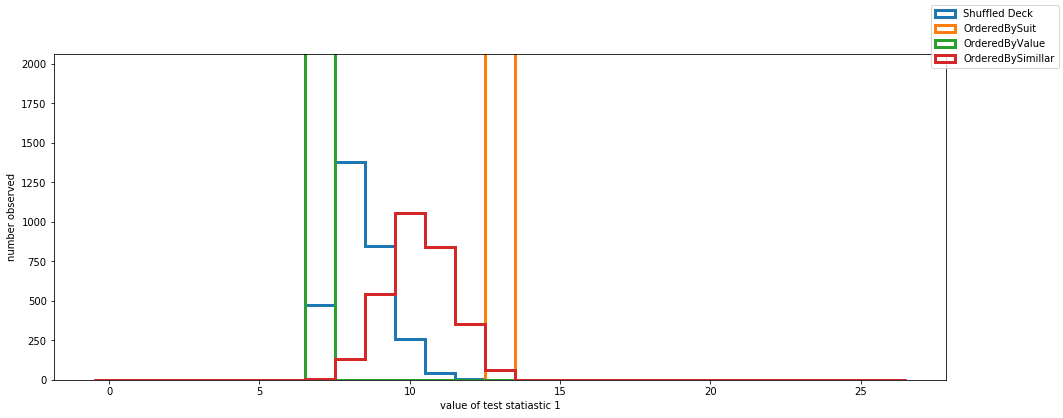

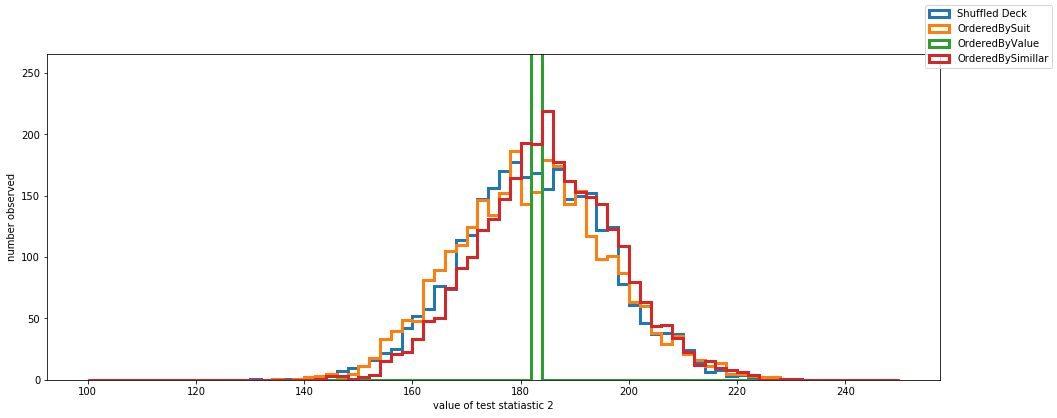

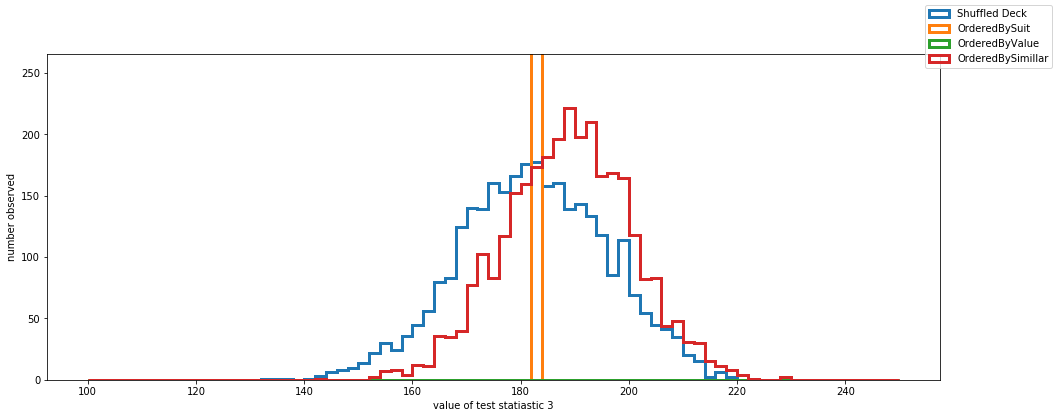

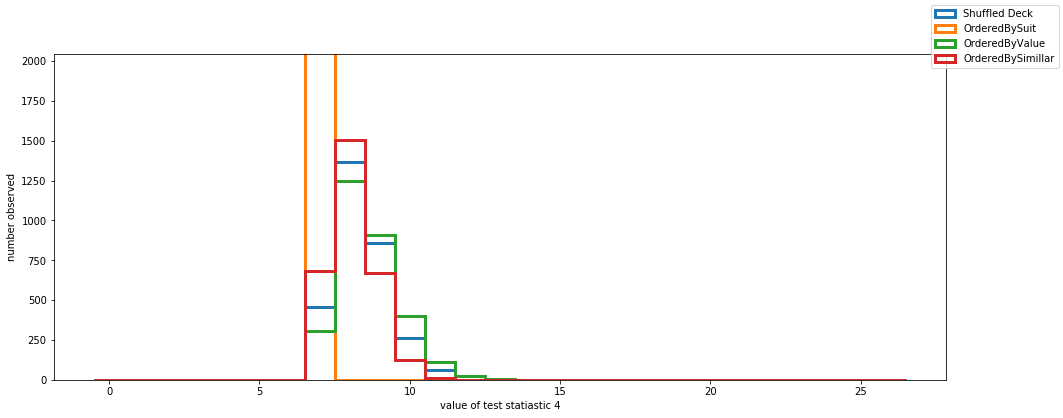

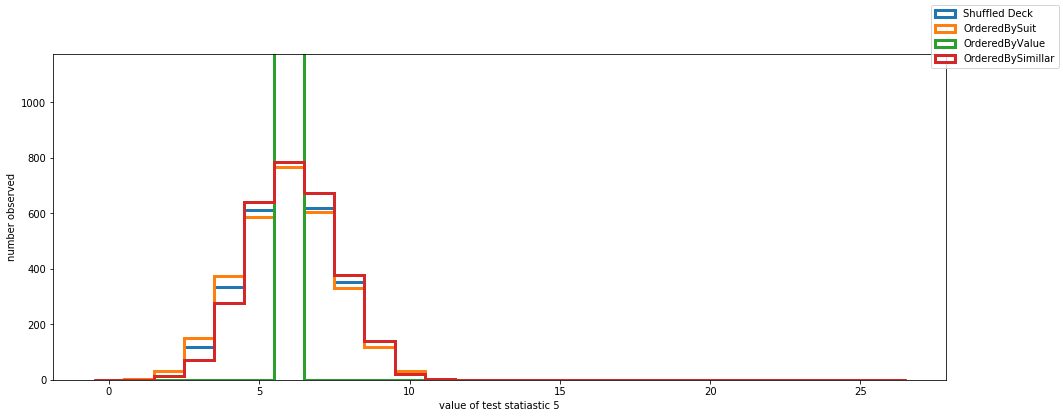

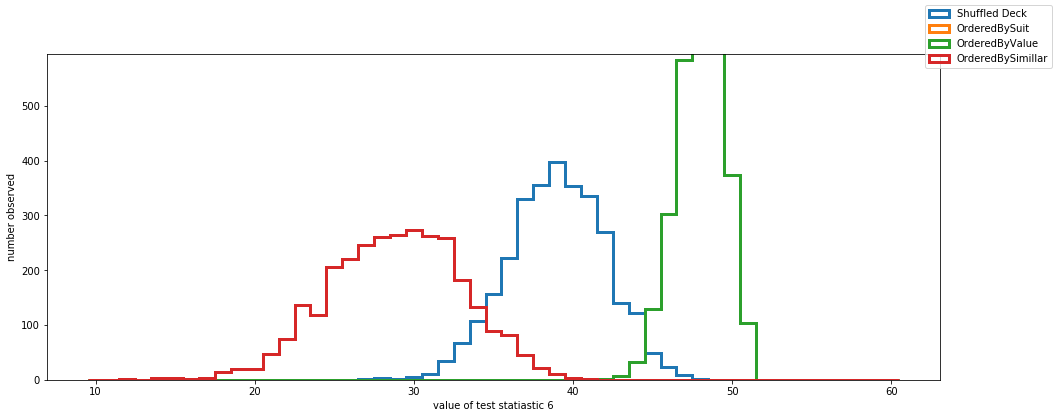

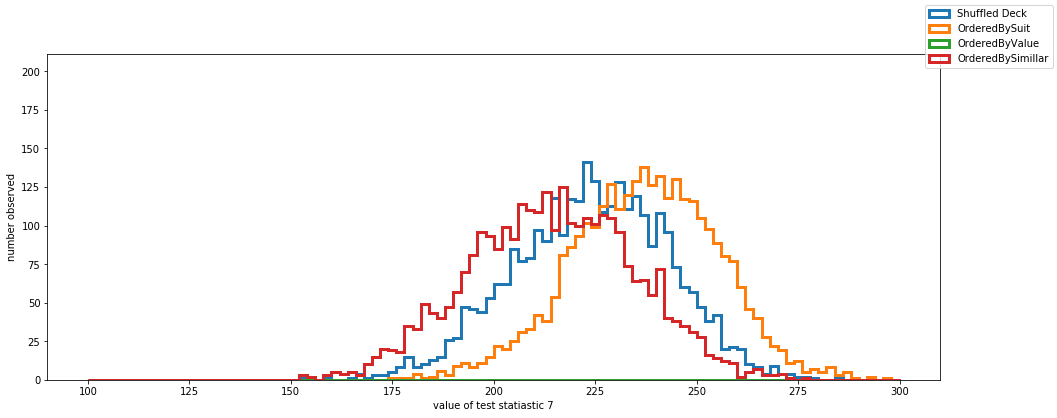

In [67]:
#lets create some decks ordered in some specific ways, to see how their distributions will shake out:



results_ordered=np.zeros((N,M,L))

def orderByValue():
    Ordered=Deck.copy() # copy base deck
    for i in range(13):
        Ordered[i*4:i*4+4,0]=i+1
        Ordered[i*4:i*4+4,1]=np.arange(4)+1
        r.shuffle(Ordered[i*4:i*4+4,1])
    return Ordered

def orderBySuit():
    Ordered=Deck.copy() # copy base deck
    r.shuffle(Ordered[0:13]) # shuffle the deck
    r.shuffle(Ordered[13:26])
    r.shuffle(Ordered[26:39])
    r.shuffle(Ordered[39:52])
    return Ordered

def orderByPickingSimillar(eta=1,suitbuff=1,valuebuff=1):#Order the cards by preferrentially picking a simmilar card to follow each card, i.e. same suit or close in value
    Drawpile=list(Deck.copy()) # copy base deck
    Ordered=Deck.copy() # copy base deck
    
    pickedCards=0
    
    while (pickedCards<len(Deck)): #we need to find cards until we draw whole deck
        draw=r.randint(0,len(Drawpile)) #draw a card
        cardDrawn=[Drawpile[draw][0],Drawpile[draw][1]]
        if pickedCards==0: #always accept first
            Ordered[pickedCards,0]=cardDrawn[0]
            Ordered[pickedCards,1]=cardDrawn[1]
            pickedCards+=1
            Drawpile.pop(draw)
        else: #accept with some prob.
            var=r.random()
            
            if Ordered[pickedCards,1]==cardDrawn[1]: #we have same suit
                var=var+suitbuff #pick with higher probability
           
            var+=valuebuff/(1+np.abs(Ordered[pickedCards,0]-cardDrawn[0]))**2 #buff if we have simmilar value, goeas a 1/(diff in value +1)
            
            if var>eta:#accept
                Ordered[pickedCards,0]=cardDrawn[0]
                Ordered[pickedCards,1]=cardDrawn[1]
                pickedCards+=1
                Drawpile.pop(draw)
    
    return Ordered

def computeOrdered(orderfunc,name,l):

    for i in range(N):
        Ordered=orderfunc()
        results_ordered[i,0,l]=statistic_0(Ordered,n,m)
        results_ordered[i,1,l]=statistic_1(Ordered,n)
        results_ordered[i,2,l]=statistic_2(Ordered)
        results_ordered[i,3,l]=statistic_3(Ordered,n)
        results_ordered[i,4,l]=statistic_4(Ordered)
        results_ordered[i,5,l]=statistic_5(Ordered,m)
        results_ordered[i,6,l]=statistic_6(Ordered)
        results_ordered[i,7,l]=statistic_7(Ordered)
    
    #plot:
    countsC0,bin_edgesC0,_=axC0.hist(results_ordered[:,0,l],bins=n+1,range=(-0.5,n+0.5),label=name,histtype="step",linewidth=3)
    countsC1,bin_edgesC1,_=axC1.hist(results_ordered[:,1,l],bins=n+1,range=(-0.5,n+0.5),label=name,histtype="step",linewidth=3)
    countsC2,bin_edgesC2,_=axC2.hist(results_ordered[:,2,l],bins=75,range=(100,250),label=name,histtype="step",linewidth=3)
    countsC3,bin_edgesC3,_=axC3.hist(results_ordered[:,3,l],bins=75,range=(100,250),label=name,histtype="step",linewidth=3)
    countsC4,bin_edgesC4,_=axC4.hist(results_ordered[:,4,l],bins=n+1,range=(-0.5,n+0.5),label=name,histtype="step",linewidth=3)
    countsC5,bin_edgesC5,_=axC5.hist(results_ordered[:,5,l],bins=n+1,range=(-0.5,n+0.5),label=name,histtype="step",linewidth=3)
    countsC6,bin_edgesC6,_=axC6.hist(results_ordered[:,6,l],bins=51,range=(10-0.5,60+0.5),label=name,histtype="step",linewidth=3)
    countsC7,bin_edgesC7,_=axC7.hist(results_ordered[:,7,l],bins=100,range=(100,300),label=name,histtype="step",linewidth=3)
    
    return countsC0,bin_edgesC0,countsC1,bin_edgesC1,countsC2,bin_edgesC2,countsC3,bin_edgesC3,countsC4,bin_edgesC4,countsC5,bin_edgesC5,countsC6,bin_edgesC6,countsC7,bin_edgesC7
    
_=computeOrdered(orderBySuit,"OrderedBySuit",0)
_=computeOrdered(orderByValue,"OrderedByValue",1)
countsOC0,bin_edgesOC0,countsOC1,bin_edgesOC1,countsOC2,bin_edgesOC2,countsOC3,bin_edgesOC3,countsOC4,bin_edgesOC4,countsOC5,bin_edgesOC5,countsOC6,bin_edgesOC6,countsOC7,bin_edgesOC7=computeOrdered(orderByPickingSimillar,"OrderedBySimillar",2)

O_counts_LIST=[countsOC0,countsOC1,countsOC2,countsOC3,countsOC4,countsOC5,countsOC6,countsOC7]
O_binEdges_LIST=[bin_edgesOC0,bin_edgesOC1,bin_edgesOC2,bin_edgesOC3,bin_edgesOC4,bin_edgesOC5,bin_edgesOC6,bin_edgesOC7]

figC0.legend()    
figC1.legend()   
figC2.legend()
figC3.legend()    
figC4.legend()   
figC5.legend()
figC6.legend()
figC7.legend()
display(figC0)
display(figC1)
display(figC2)
display(figC3)
display(figC4)
display(figC5)
display(figC6)
display(figC7)
figC0.savefig("4_2_c1.png",dpi=600)
figC1.savefig("4_2_c2.png",dpi=600)
figC2.savefig("4_2_c3.png",dpi=600)
figC3.savefig("4_2_c4.png",dpi=600)
figC4.savefig("4_2_c5.png",dpi=600)
figC5.savefig("4_2_c6.png",dpi=600)
figC6.savefig("4_2_c7.png",dpi=600)
figC7.savefig("4_2_c8.png",dpi=600)


Inspecting the distributions above, we note that the very ordered decks give values as expected for the test-statistics (the sharp peaks), and serve as fine sanity-checks. Already we see that statistic 1,3,6 and 7 look to be the most promising when telling the 'similar' ordered deck from the random deck. Lets see if we can combine them to a new and better statistic using fisher.

First we plot them, to see if it looks linear:

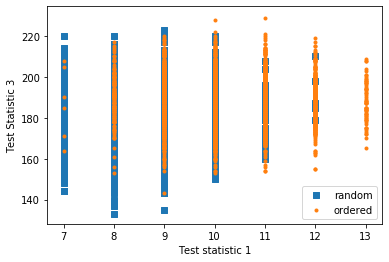

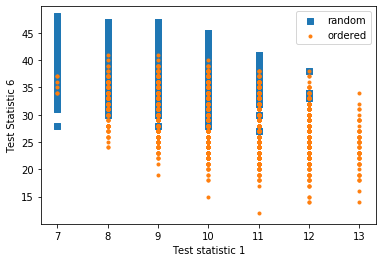

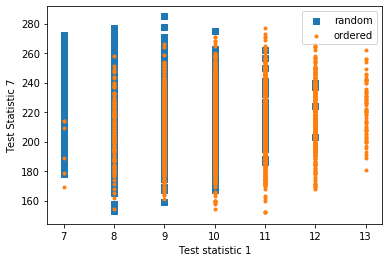

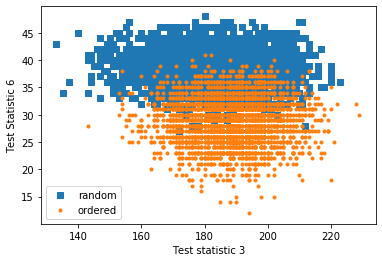

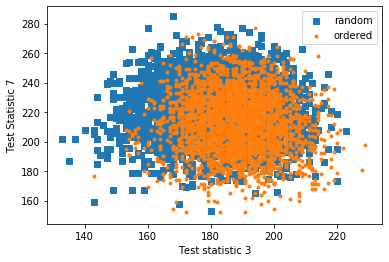

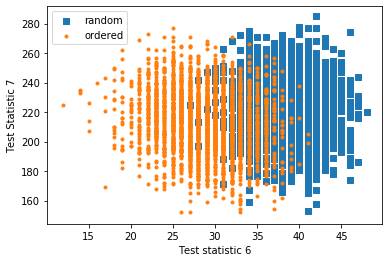

In [68]:
included=[1,3,6,7]

for i in included:
    for j in included:
        if i<j:
            plt.figure()
            plt.scatter(results[:,i],results[:,j],label="random",marker="s")
            plt.scatter(results_ordered[:,i,2],results_ordered[:,j,2],label="ordered",marker='.')
            plt.legend()
            plt.xlabel("Test statistic "+str(i))
            plt.ylabel("Test Statistic "+str(j))
            plt.savefig("4_2_"+str(i)+str(j)+".png",dpi=600)
    


We clearly see the discrete nature of the statistics, and that everything looks linear. 
Lets combine:

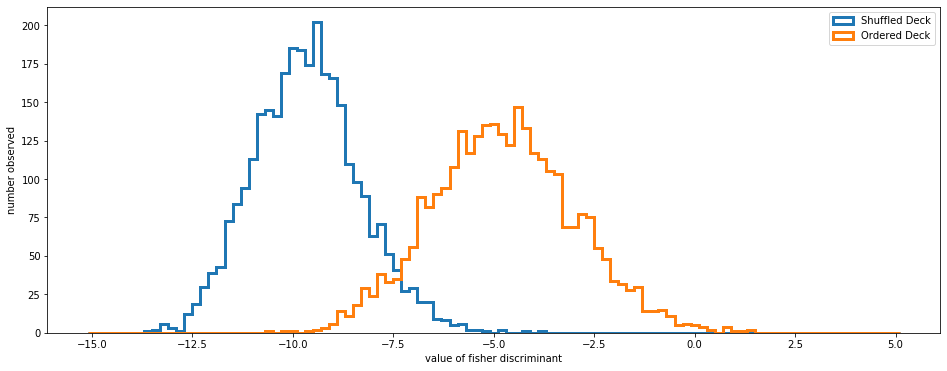

In [69]:
mu_order=[]
mu_random=[]

Ordered_included=[]
random_included=[]

for i in included:
    mu_order.append(np.mean(results_ordered[:,i,2]))
    mu_random.append(np.mean(results[:,i]))
    
    Ordered_included.append(results_ordered[:,i,2])
    random_included.append(results[:,i])
    

Ordered_included=np.array(Ordered_included)
random_included=np.array(random_included)


mu_order=np.array(mu_order)
mu_random=np.array(mu_random)    

cov_ordered=np.cov(Ordered_included)
cov_random=np.cov(random_included)

cov_sum=cov_ordered+cov_random

w=np.matmul(np.linalg.inv(cov_sum),(mu_order-mu_random))

w0=0

F_order=w0+np.dot(w,Ordered_included)
F_random=w0+np.dot(w,random_included)


figF, axF = plt.subplots(figsize=(16, 6));

#calculate binning:
#(To get that there is a bin with the min and max value of the range)
Bins=101
Fmin=-15
Fmax=5
offset=((Fmax-Fmin)/(Bins-1))/2
Fmin=Fmin-offset
Fmax=Fmax+offset

countsFR,bin_edgesFR,_=axF.hist(F_random,bins=Bins,range=(Fmin,Fmax),label="Shuffled Deck",histtype="step",linewidth=3)
countsFO,bin_edgesFO,_=axF.hist(F_order,bins=Bins,range=(Fmin,Fmax),label="Ordered Deck",histtype="step",linewidth=3)

binvalues=(bin_edgesFO[1::]+bin_edgesFO[0:-1])/2

plt.ylabel("number observed")
plt.xlabel("value of fisher discriminant")
plt.legend()
plt.savefig("4_2_c9.png",dpi=600)

To illustrate the performance of the different test, we will make a roc-curve:

statistic 1 Value: 9.0
probability of ruling shuffled as ordered: 0.10066666666666667
probability of ruling ordered as shuffled: 0.2283333333333334
statistic 3 Value: 169.0
probability of ruling shuffled as ordered: 0.8183333333333334
probability of ruling ordered as shuffled: 0.052000000000000046
statistic 6 Value: 37.0
probability of ruling shuffled as ordered: 0.204
probability of ruling ordered as shuffled: 0.027000000000000024
statistic 7 Value: 249.0
probability of ruling shuffled as ordered: 0.9033333333333333
probability of ruling ordered as shuffled: 0.04600000000000004
Fisher statistic Value: -7.6
probability of ruling shuffled as ordered: 0.058
probability of ruling ordered as shuffled: 0.06066666666666665


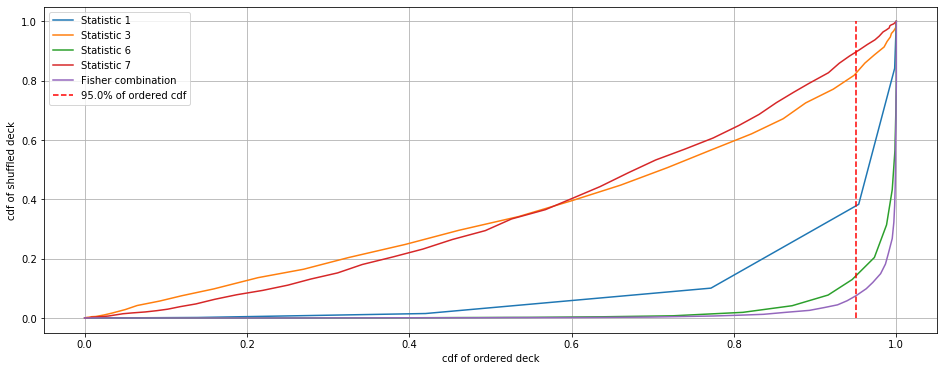

In [70]:

figROC, axROC = plt.subplots(figsize=(16, 6));

c=0.95 # 1 minus the significance

for i in included:# For every statistic we used
    bin_edgesS,bin_edgesO,countsS,countsO=np.array(S_binEdges_LIST[i]),np.array(O_binEdges_LIST[i]),S_counts_LIST[i],O_counts_LIST[i] #unpack
    
    binValuesS=(bin_edgesS[0:-1]+bin_edgesS[1::])/2
    binValuesO=(bin_edgesO[0:-1]+bin_edgesO[1::])/2
    
    #Make sure we put all in the same corner:
    if np.mean(results_ordered[:,i,2])<np.mean(results[:,i]):
        cdfS=np.array([np.sum(countsS[0:i])/np.sum(countsS) for i in range(len(countsS))])
        cdfO=np.array([np.sum(countsO[0:i])/(np.sum(countsO)) for i in range(len(countsO))])
        cufoff=np.min(binValuesO[cdfO>c])
        cutoffarg=np.argmin(np.abs(binValuesO-cufoff))
    else:
        cdfS=np.array([np.sum(countsS[len(countsS)-i::])/np.sum(countsS) for i in range(len(countsS))])
        cdfO=np.array([np.sum(countsO[len(countsO)-i::])/(np.sum(countsO)) for i in range(len(countsO))])
        cufoff=np.min(np.flip(binValuesO)[cdfO<c])
        cutoffarg=np.argmin(np.abs(np.flip(binValuesO)-cufoff))
        
    print(f"statistic {i} Value: {cufoff}")
    print(f"probability of ruling shuffled as ordered: {cdfS[cutoffarg]}")
    print(f"probability of ruling ordered as shuffled: {1-cdfO[cutoffarg]}")
    
    axROC.plot(cdfO,cdfS,label="Statistic "+str(i))
    
    
#now the fisher-statistic:

cdfS=np.array([np.sum(countsFR[len(countsFR)-i::])/np.sum(countsFR) for i in range(len(countsFR))])
cdfO=np.array([np.sum(countsFO[len(countsFO)-i::])/(np.sum(countsFO)) for i in range(len(countsFO))])

binValuesS=(bin_edgesFR[0:-1]+bin_edgesFR[1::])/2
binValuesO=(bin_edgesFO[0:-1]+bin_edgesFO[1::])/2

cufoff=np.min(np.flip(binValuesO)[cdfO<c])
cutoffarg=np.argmin(np.abs(np.flip(binValuesO)-cufoff))
print(f"Fisher statistic Value: {cufoff}")
print(f"probability of ruling shuffled as ordered: {cdfS[cutoffarg]}")
print(f"probability of ruling ordered as shuffled: {1-cdfO[cutoffarg]}")

axROC.plot(cdfO,cdfS,label="Fisher combination")
    
axROC.plot([c,c],[0,1],linestyle="--",color='r',label=str(c*100)+"% of ordered cdf")
axROC.legend()
plt.ylabel("cdf of shuffled deck")
plt.xlabel("cdf of ordered deck")
plt.grid()
plt.savefig("4_2_c10.png",dpi=600)

We see that the combined statistic is the best performing, closely followed by statistic 6. 
We had to make a difficult choice: Where do we set the cutoff for our hypothesis-test? Since there is no context for the test, we arbitrarily have to pick if we want to risk falsely judging a shuffled deck to be ordered, or a ordered deck to be shuffled. 
Since the chance of ruling a shuffled deck as ordered rises rapidly after this, I picked 5% chance to rule a ordered deck as shuffled as where we want to be. This means that our statistic-value for making a descision -7.6 for the fisher. If a deck has a value lower than this, we rule it as a shuffled deck. We will wrongly rule 5.8% of shuffled decks as orderd this way.

Now we actually do the test:

In [71]:
troelsVector=np.ones(M)
troelsVector[0]=statistic_0(Troels_deck,n,m)
troelsVector[1]=statistic_1(Troels_deck,n)
troelsVector[2]=statistic_2(Troels_deck)
troelsVector[3]=statistic_3(Troels_deck,n)
troelsVector[4]=statistic_4(Troels_deck)
troelsVector[5]=statistic_5(Troels_deck,m)
troelsVector[6]=statistic_6(Troels_deck)
troelsVector[7]=statistic_7(Troels_deck)

troels_included=[]

for i in included:
    troels_included.append(troelsVector[i])
troels_included=np.array(troels_included)

F_troels=w0+np.dot(w,troels_included)
print(f"Troels' deck has a test-statistic of: {F_troels} for the combined")
print("The individual test-statics values are:")
print(troelsVector)


Troels' deck has a test-statistic of: -8.568402002777994 for the combined
The individual test-statics values are:
[  7.  11. 237. 202.   8.  12.  41. 231.]


Since this is lower than -7.6, we rule that the deck is not ordered with similar cards following each other. I.e. we reject the hypothesis and must accept the alternative. 
Of course this is not a defnitive answer to the question 'are the cards well shuffled'. We only compared the deck to a single 'type' of ordering - which I just arbitrarily decided. However we can state that we refuted the 'hypopthesis' that the cards were ordered according to a specific set of rules I made, according to a test with significance 5% and power 94.2%.

If we look at the individual test-statistics, we see that for statistcs 2 and 5, Troels's deck is pretty far out in the tails of the simulated random distributions. These are the tests that look at every second card in the deck and compute their sum and how many are picture-cards. This might impy that Troels's deck does not belong to the distribution of the perfectly shuffled cards, but to a distribution of cards ordered such that every second card has a high value. However, to determine this we would need to do further statistical tests. 

Lets just do a simple one: We will simulate the distributions for statistic 2 and 5 enough times that we also get something in the tails, and then compute what percentage of random decks are further from the mean than Troel's deck. (two tailed test) Since we only have one sample from Troels, we cannot compute a variance. Had he instead supplied a few decks, we could have done a t-test to see if they were compatible with the shuffled distribution.

In [72]:
N=1000000

results25=np.zeros((N,2))

for i in range(N):
    Shuffled=Deck.copy() # copy base deck
    r.shuffle(Shuffled) # shuffle the deck
    results25[i,0]=statistic_2(Shuffled)
    results25[i,1]=statistic_5(Shuffled,m)




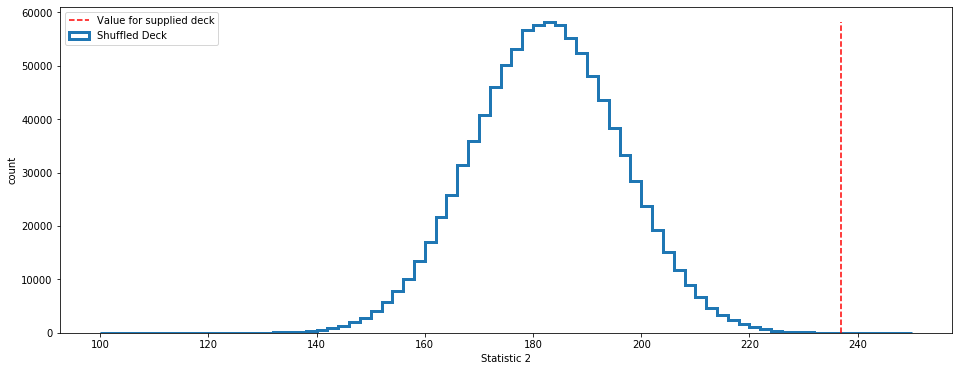

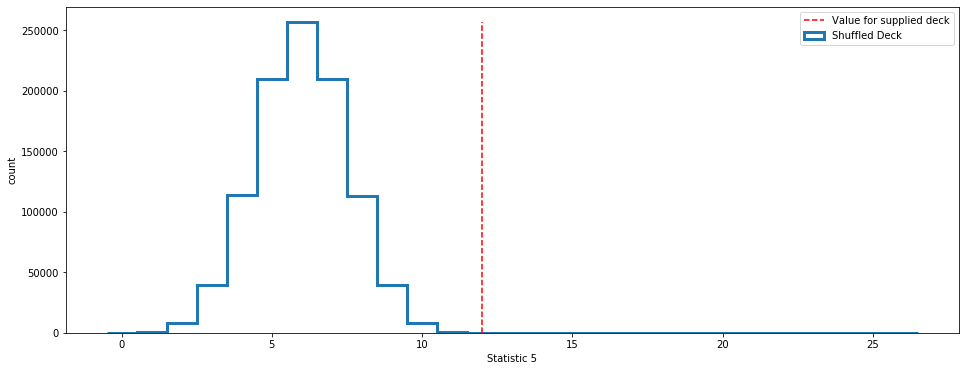

In [73]:
figT2, axT2 = plt.subplots(figsize=(16, 6));
countsT2,bin_edgesT2,_=axT2.hist(results25[:,0],bins=75,range=(100,250),label="Shuffled Deck",histtype="step",linewidth=3)
plt.xlabel("Statistic 2")
plt.ylabel("count")

axT2.plot([troelsVector[2],troelsVector[2]],[0,np.max(countsT2)],color='r',linestyle='--',label="Value for supplied deck")
plt.legend()

figT5, axT5 = plt.subplots(figsize=(16, 6));
countsT5,bin_edgesT5,_=axT5.hist(results25[:,1],bins=n+1,range=(0-0.5,n+0.5),label="Shuffled Deck",histtype="step",linewidth=3)
plt.xlabel("Statistic 5")
plt.ylabel("count")

axT5.plot([troelsVector[5],troelsVector[5]],[0,np.max(countsT5)],color='r',linestyle='--',label="Value for supplied deck")
plt.legend()

figT2.savefig("4_2_c11.png",dpi=600)
figT5.savefig("4_2_c12.png",dpi=600)

In [74]:
mu_T2=np.mean(results25[:,0])
mu_T5=np.mean(results25[:,1])

vT2=np.abs(troelsVector[2]-mu_T2)
vT5=np.abs(troelsVector[5]-mu_T5)
NT2=np.sum(np.abs(results25[:,0]-mu_T2)>=vT2)
NT5=np.sum(np.abs(results25[:,1]-mu_T5)>=vT5)

print(f"p-value for having same or larger distance from the mean, compared to Troels's deck: {NT2/N} for Test 2 and {NT5/N} for Test 5")


p-value for having same or larger distance from the mean, compared to Troels's deck: 2.7e-05 for Test 2 and 4e-05 for Test 5


With these astonishingly small p-values, I conclude that I find it very unlikely that the deck supplied belongs to the populatin of perfectly shuffled decks. 

### Problem 5

#### 5.1
##### a)
We are asked to plot the price of solar power over the cumultative solar power capacity.

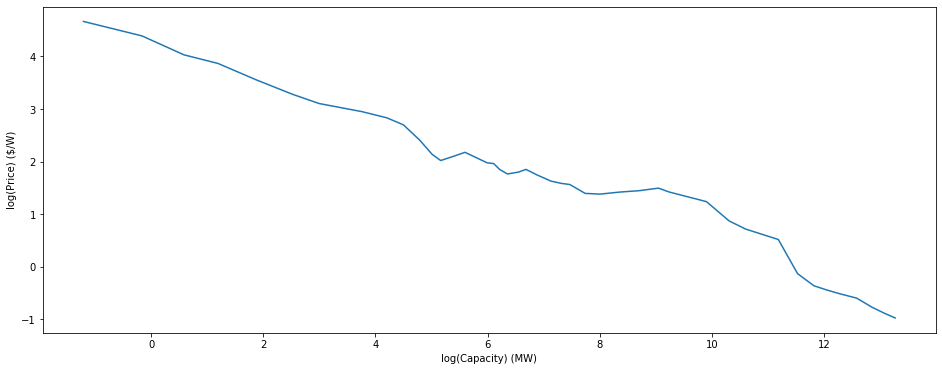

In [75]:
year, capacity, price = np.loadtxt("data_SolarPower.txt", skiprows=2, delimiter="\t", unpack=True)

figS, axS = plt.subplots(figsize=(16, 6));
axS.plot(np.log(capacity),np.log(price))
plt.xlabel("log(Capacity) (MW)")
plt.ylabel("log(Price) ($/W)")

plt.savefig("5_1_a2.png",dpi=600)

##### b)
We now want to fit this with a power-law.


Chi2 value: 86.6   Ndof = 42    Prob(Chi2,Ndof) = 6.226375142817107e-05


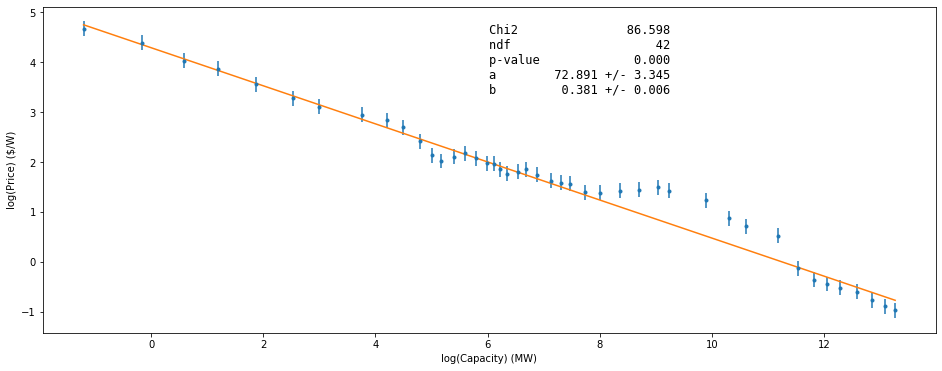

In [76]:
price_error = price*0.15 #15% error

def f(x,a,b):
    return a*x**(-b)

def f_chi2(a,b):
    return np.sum(((f(capacity,a,b)-price)/price_error)**2)

f_chi2.errordef = 1.0
minuit = Minuit(f_chi2, a=1,b=1)
minuit.migrad()

a_fit = minuit.values['a']
b_fit = minuit.values['b']

figS, axS = plt.subplots(figsize=(16, 6));
axS.errorbar(np.log(capacity),np.log(price),yerr=price_error/price,fmt='.') # error from error-propagation 
plt.xlabel("log(Capacity) (MW)")
plt.ylabel("log(Price) ($/W)")

x=np.linspace(np.min(capacity),np.max(capacity),1000)
axS.plot(np.log(x),np.log(f(x,a_fit,b_fit)))

chi2=f_chi2(a_fit,b_fit)
Ndof_value = len(price) - 2 #2 fit parameters

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

d = {'Chi2':     chi2,
     'ndf':      Ndof_value,
     'p-value':  stats.chi2.sf(chi2, Ndof_value)
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.5, 0.95, text, axS, fontsize=12)


plt.savefig("5_1_b1.png",dpi=600)

The p-value is very small, so the realtionship is probably not well described by a power-law. We could also have fitted analytically in log-space, since all uncertainties are the same, and a power law is a straight line in this space. But why do hard work, when minuit can do it for us?

##### c)
We now look at capacity as a function of year:

Text(0, 0.5, 'log(capacity) (MW)')

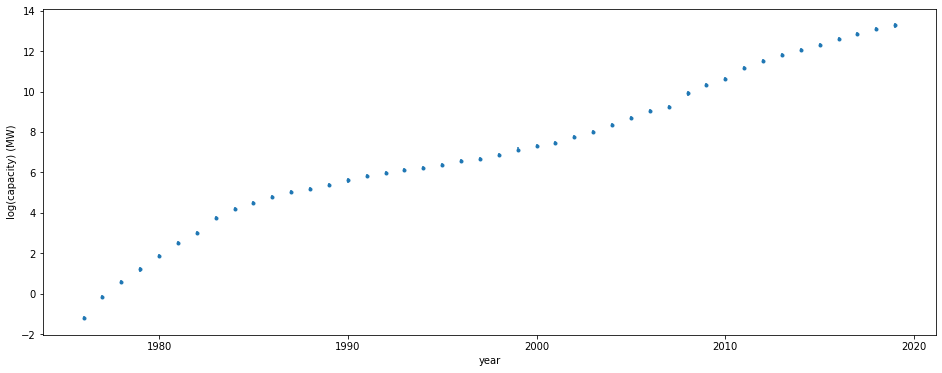

In [77]:
figS, axS = plt.subplots(figsize=(16, 6));
capacity_error=capacity*0.1 # Assume some 10% error 
axS.errorbar(year,np.log(capacity),yerr=capacity_error/capacity,fmt='.') 
plt.xlabel("year")
plt.ylabel("log(capacity) (MW)")

That looks essentially linear, so lets fit an exponential:

Chi2 value: 1209.1   Ndof = 41    Prob(Chi2,Ndof) = 9.288846369725776e-227


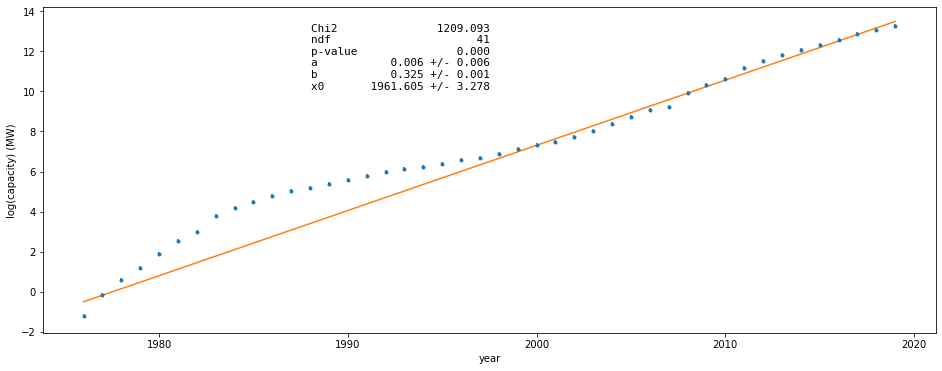

In [78]:
def f_exp(x,a,b,x0):
    return a*np.exp((x-x0)*b)

def f_chi2(a,b,x0):
    return np.sum(((f_exp(year,a,b,x0)-capacity)/capacity_error)**2)

f_chi2.errordef = 1.0
minuit = Minuit(f_chi2, a=1,b=0.5,x0=1980)
minuit.migrad()

a_exp_fit = minuit.values['a']
b_exp_fit = minuit.values['b']
x0_fit = minuit.values['x0']

figS, axS = plt.subplots(figsize=(16, 6));
axS.errorbar(year,np.log(capacity),yerr=capacity_error/capacity,fmt='.') 
plt.xlabel("year")
plt.ylabel("log(capacity) (MW)")

x=np.linspace(np.min(year),np.max(year),1000)
axS.plot(x,np.log(f_exp(x,a_exp_fit,b_exp_fit,x0_fit)))

chi2=f_chi2(a_exp_fit,b_exp_fit,x0_fit)
Ndof_value = len(capacity) - 3

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")


d = {'Chi2':     chi2,
     'ndf':      Ndof_value,
     'p-value':  stats.chi2.sf(chi2, Ndof_value)
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.3, 0.95, text, axS, fontsize=11)

figS.savefig("5_1_c1.png",dpi=600)


The p-value is microscopic, so either the behaviour is not really exponential, or the 10% was to low an estimate for the error. 

We now want determine when this reaches a million, and what the price will be then. 

In [79]:
x=np.linspace(2010,2050,1000)

capacity_model=f_exp(x,a_exp_fit,b_exp_fit,x0_fit)

M=1e6 #capacity we look for

YM=np.min(x[capacity_model>M])

print(f"We reach 1 million MW in {YM:.0f}")
print(f"The modelled price is: {f(M,a_fit,b_fit):.3f} $/W")


We reach 1 million MW in 2020
The modelled price is: 0.375 $/W


#### 5.2
##### a)
We now consider another dataset consisting of the number of daily tests and positive test of a disease. 

In [80]:
date, Ntests, Npositives = np.loadtxt("data_Covid19tests.txt", skiprows=2, unpack=True)

We are asked first to find the average number of daily tests:

In [81]:
N_average=np.mean(Ntests)
N_average_std=np.std(Ntests,ddof=1)

print(f"The average daily number of tests is: {N_average:.2f} with RMS of {N_average_std:.2f}")

The average daily number of tests is: 83090.07 with RMS of 17866.92


##### b)
We now define:

$SP_i=P_i \cdot (\frac{T_i}{\hat{T}})^{-0.7}$

Where $\hat{T}$ is the average number of tests.

We want to fit this with:

$SP_0 \cdot R^{(t-t_0)/T_G}$

with $T_G = 4.7$

Text(0, 0.5, 'SP')

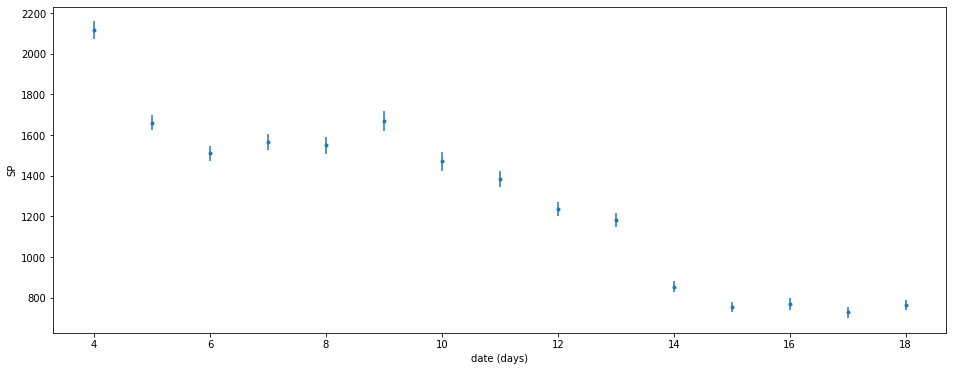

In [82]:
#Compute scaled positives:
SP=Npositives * (Ntests/N_average)**(-0.7)
SP_e=np.sqrt(Npositives) * (Ntests/N_average)**(-0.7) #assume only error is from Npositives, and given by sqrt(poisson stats), could also include error on T_average

#plot so we can have a look:
figSP, axSP = plt.subplots(figsize=(16, 6));
axSP.errorbar(date,SP,yerr=SP_e,fmt='.',label="Data")
plt.xlabel("date (days)")
plt.ylabel("SP")


Now lets do the fitting:

Chi2 value: 228.3   Ndof = 12    Prob(Chi2,Ndof) = 4.404831500925064e-42


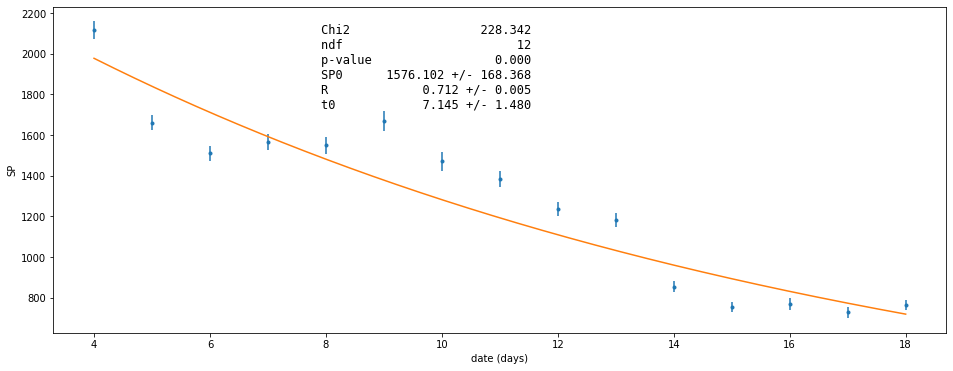

In [83]:
TG=4.7
def fit_func(t,SP0,R,t0):
    return SP0 * R**((t-t0)/TG)

def f_chi2(SP0,R,t0):
    return np.sum(((fit_func(date,SP0,R,t0)-SP)/SP_e)**2)

f_chi2.errordef = 1.0
minuit = Minuit(f_chi2, SP0=2000,R=1,t0=4)
minuit.migrad()

x=np.linspace(np.min(date),np.max(date),1000)
axSP.plot(x,fit_func(x,*minuit.values[:]),label="fit")
#axSP.legend()

chi2=f_chi2(*minuit.values[:])
Ndof_value = len(date) - 3

Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value}")

d = {'Chi2':     chi2,
     'ndf':      Ndof_value,
     'p-value':  stats.chi2.sf(chi2, Ndof_value)
    }

for name in minuit.parameters:
    d[name] = [minuit.values[name], minuit.errors[name]]

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.3, 0.95, text, axSP, fontsize=12)

figSP.savefig("5_2_b1.png",dpi=600)
figSP


##### c)

We now consider how large a systematic error we must apply on SP for the fit to give a reasoanble p-value. 

Our approach will be to consider different systematic uncertainties, and compute the p-value for each.
We would consider at p-value between 0.05 and 0.95 reasonable in most cases, so lets look for this range. 


P-value of 0.05 at systematic error on SP of 86.09
P-value of 0.95 at systematic error on SP of 211.81


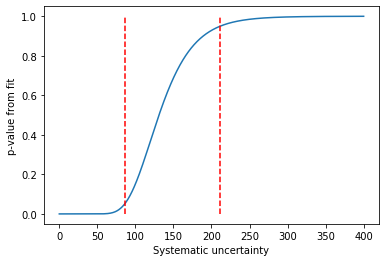

In [84]:
emin=0
emax=400

N=1000

sys_e=np.linspace(emin,emax,N)
p=np.zeros(N)

for i,se in enumerate(sys_e):
    chi2=np.sum(((SP-fit_func(date,*minuit.values[:]))/(SP_e+se))**2)
    Prob_value = stats.chi2.sf(chi2, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
    p[i]=Prob_value

plt.plot(sys_e,p)
plt.xlabel("Systematic uncertainty")
plt.ylabel("p-value from fit")

E_needed=np.min(sys_e[p>0.05])
E_max=np.min(sys_e[p>0.95])

plt.plot([E_needed,E_needed],[0,1],'r',linestyle="--")
plt.plot([E_max,E_max],[0,1],'r',linestyle="--")

print(f"P-value of 0.05 at systematic error on SP of {E_needed:.2f}")
print(f"P-value of 0.95 at systematic error on SP of {E_max:.2f}")

plt.savefig("5_2_c1.png",dpi=600)

##### d)
We now want to consider the uncertainty on the paramenter R, given an uncertainty of $\pm 1$ day on $T_G$

I dont remember the good way of doing this, so I will solve it using simulation

R=0.71 +- 0.05


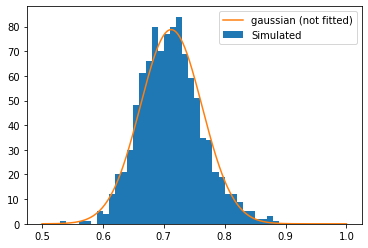

In [85]:
r.seed(1) #set seed
N=1000 #number of times to do fit
TG=4.7+r.normal(loc=0,scale=1,size=N) #generate TG according to 4.7 +- 1.0

Results=np.zeros(N)

for n in range(N):

    def fit_func(t,SP0,R,t0):
        return SP0 * R**((t-t0)/TG[n])

    def f_chi2(SP0,R,t0):
        return np.sum(((fit_func(date,SP0,R,t0)-SP)/SP_e)**2)

    f_chi2.errordef = 1.0
    minuit = Minuit(f_chi2, SP0=2000,R=1,t0=4)
    minuit.migrad()
    Results[n]=minuit.values["R"]
    
counts,binedges,_=plt.hist(Results,range=(0.5,1.0),bins=50,label="Simulated")
binvalues=(binedges[0:-1]+binedges[1::])/2
binwidth=binvalues[1]-binvalues[0]

R=np.mean(Results)
Re=np.std(Results,ddof=1)

x=np.linspace(0.5,1,1000)
plt.plot(x,N*binwidth*stats.norm.pdf(x,loc=R,scale=Re),label="gaussian (not fitted)")
plt.legend()

print(f"R={R:.2f} +- {Re:.2f}")
plt.savefig("5_2_d1.png",dpi=600)

We see that the obtained R's follow a gaussin when we do the fit with different TG's with a gaussian error. The obtained error on R is 0.05 from an error of 1 day on TG. 